In [1]:
import sys
sys.path.append('../') 

In [2]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
from shared_models import SharedModel
from collections import defaultdict 



## Params:

In [3]:
aggregate_by_state = False
outcome_type = 'deaths'

## Basic Data Visualization

In [4]:
# Just something to quickly summarize the number of cases and distributions each day

In [5]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'Respiratory Mortality',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [151]:
neighboring_counties_df = pd.read_csv('../data_new/county_level/raw/county_ids/county_adjacency2010.csv')

In [141]:
for c in df.columns:
    if 'County' in c or 'county' in c:
        print(c)

CountyName
CountyNamew/StateAbbrev
FIPSCountyCode
CBSACountyStatusCentralorOutlying2018
HPSACode-PrimaryCare05/191=Whole,2=PartCounty2019
HPSACode-PrimaryCare05/181=Whole,2=PartCounty2018
HPSACode-PrimaryCare05/171=Whole,2=PartCounty2017
HPSACode-PrimaryCare05/161=Whole,2=PartCounty2016
HPSACode-PrimaryCare06/151=Whole,2=PartCounty2015
HPSACode-PrimaryCare12/101=Whole,2=PartCounty2010
HPSACode-Dentists05/191=Whole,2=PartCounty2019
HPSACode-Dentists05/181=Whole,2=PartCounty2018
HPSACode-Dentists05/171=Whole,2=PartCounty2017
HPSACode-Dentists05/161=Whole,2=PartCounty2016
HPSACode-Dentists06/151=Whole,2=PartCounty2015
HPSACode-Dentists12/101=Whole,2=PartCounty2010
HPSACode-MentalHealth05/191=Whole,2=PartCounty2019
HPSACode-MentalHealth05/181=Whole,2=PartCounty2018
HPSACode-MentalHealth05/171=Whole,2=PartCounty2017
HPSACode-MentalHealth05/161=Whole,2=PartCounty2016
HPSACode-MentalHealth06/151=Whole,2=PartCounty2015
HPSACode-MentalHealth12/101=Whole,2=PartCounty2010
ContiguousCounty#1
Conti

In [142]:
df['CountyNamew/StateAbbrev']


1824       Kings, NY
1841      Queens, NY
1803       Bronx, NY
1831    New York, NY
1830      Nassau, NY
            ...     
2654       Mason, TX
2624     Kendall, TX
1915         Lee, NC
2375     Lincoln, SD
3047      Juneau, WI
Name: CountyNamew/StateAbbrev, Length: 2503, dtype: object

In [152]:
neighboring_counties['countyname'] = [n.split(',')[0] for ] 


SyntaxError: invalid syntax (<ipython-input-152-e29904681e05>, line 1)

In [198]:
for i,c in enumerate(list(neighboring_counties_df['countyname'])):
    if 'Orleans' in c:
        print(neighboring_counties_df.iloc[i])

countyname        Orleans Parish, LA
fipscounty                     22071
neighborname    Jefferson Parish, LA
fipsneighbor                   22051
Name: 7944, dtype: object
countyname      Orleans Parish, LA
fipscounty                   22071
neighborname    Orleans Parish, LA
fipsneighbor                 22071
Name: 7945, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    Plaquemines Parish, LA
fipsneighbor                     22075
Name: 7946, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    St. Bernard Parish, LA
fipsneighbor                     22087
Name: 7947, dtype: object
countyname          Orleans Parish, LA
fipscounty                       22071
neighborname    St. Tammany Parish, LA
fipsneighbor                     22103
Name: 7948, dtype: object
countyname      Orleans County, NY
fipscounty                   36073
neighborname    Genesee County, NY
fipsneigh

In [199]:
neighboring_counties_df['countyname_clean'] = [n.split()[0] + ', '+ n.split()[-1] for n in list(neighboring_counties_df['countyname'])]
neighboring_counties_df['neighborname_clean'] = [n.split()[0] + ', '+ n.split()[-1] for n in list(neighboring_counties_df['neighborname'])]

In [206]:
df['countyFIPS']


1824    36047
1841    36081
1803    36005
1831    36061
1830    36059
        ...  
2654    48319
2624    48259
1915    37105
2375    46083
3047    55057
Name: countyFIPS, Length: 2503, dtype: int64

In [204]:
for c in df.columns:
    if 'FIPS' in c:
        print(c)

Header-FIPSStandCtyCode
FIPSStateCode
FIPSCountyCode
countyFIPS


In [200]:
neighboring_counties_df


countyname  fipscounty           neighborname  fipsneighbor  \
0         Autauga County, AL        1001     Autauga County, AL          1001   
1         Autauga County, AL        1001     Chilton County, AL          1021   
2         Autauga County, AL        1001      Dallas County, AL          1047   
3         Autauga County, AL        1001      Elmore County, AL          1051   
4         Autauga County, AL        1001     Lowndes County, AL          1085   
...                      ...         ...                    ...           ...   
22195   St. Croix Island, VI       78010   St. Croix Island, VI         78010   
22196    St. John Island, VI       78020    St. John Island, VI         78020   
22197    St. John Island, VI       78020  St. Thomas Island, VI         78030   
22198  St. Thomas Island, VI       78030    St. John Island, VI         78020   
22199  St. Thomas Island, VI       78030  St. Thomas Island, VI         78030   

      countyname_clean neighborname_clean  
0          Autauga, AL        Autauga, AL  
1          Autauga, AL        Chilton, AL  
2          Autauga, AL         Dallas, AL  
3          Autauga, AL         Elmore, AL  
4          Autauga, AL        Lowndes, AL  
...                ...                ...  
22195          St., VI            St., VI  
22196          St., VI            St., VI  
22197          St., VI            St., VI  
22198          St., VI            St., VI  
22199          St., VI            St., VI  

[22200 rows x 6 columns]

In [472]:
county_neighbor_deaths = []
county_neighbor_cases = []
county_fips = list(df['countyFIPS'])
for fips in county_fips:


    neighboring_counties = list(neighboring_counties_df.loc[neighboring_counties_df['fipscounty'] == fips ]['fipsneighbor'])
    neighboring_county_deaths = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['deaths'])
    neighboring_county_cases = list(df.loc[df['countyFIPS'].isin(neighboring_counties)]['cases'])
    
    sum_neighboring_county_deaths = np.zeros(len(neighboring_county_deaths[0]))
    for deaths in neighboring_county_deaths:
        sum_neighboring_county_deaths += deaths
    sum_neighboring_county_cases = np.zeros(len(neighboring_county_deaths[0]))
    for cases in neighboring_county_cases:
        sum_neighboring_county_cases += cases
    county_neighbor_deaths.append(sum_neighboring_county_deaths)
    county_neighbor_cases.append(sum_neighboring_county_cases)


        


    
    
    




In [473]:
df['neighbor_deaths'] = county_neighbor_deaths
df['neighbor_cases'] = county_neighbor_cases


In [474]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
2503


(array([168.,  95.,  69.,  55.,  34.,  35.,  26.,  24.,  18.,  20.,  17.,
         12.,  11.,  11.,  15.,   8.,   7.,   6.,  10.,   8.,   7.,   4.,
          6.,   5.,   5.,   6.,   4.,   3.,   2.,   8.,   2.,   2.,   5.,
          1.,   2.,   6.,   2.,   2.,   2.,   3.,   3.,   1.,   2.,   1.,
          2.,   1.,   0.,   0.,   2.,   0.,   1.,   2.,   2.,   2.,   1.,
          2.,   1.,   1.,   2.,   0.,   2.,   1.,   1.,   2.,   1.,   0.,
          1.,   0.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,   1.,   2.,
          1.,   0.,   1.,   2.,   0.,   0.,   3.,   0.,   0.,   0.,   1.,
          2.,   2.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   1.,
          1.]),
 array([ 21.  ,  30.76,  40.52,  50.28,  60.04,  69.8 ,  79.56,  89.32,
         99.08, 108.84, 118.6 , 128.36, 138.12, 147.88, 157.64, 167.4 ,
        177.16, 186.92, 196.68, 206.44, 216.2 , 225.96, 235.72, 245.48,
        255.24, 265.  , 274.76, 284.52, 294.28, 304.04, 313.8 , 323.56,
        333.32, 343.08, 352.84

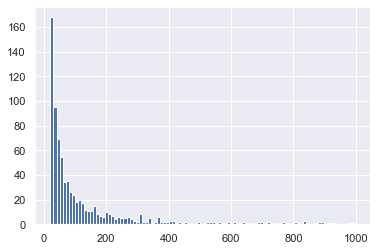

In [475]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [476]:
sum(max_cases)

389718

In [477]:
print(sum([v > 50 for v in max_cases]))


516


In [478]:
np.quantile(max_cases,.5)

9.0

Number of counties with non-zero deaths
833


(array([189.,  16.,   6.,   3.,   3.,   3.,   3.,   1.,   0.,   0.,   1.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([   6.        ,   44.23333333,   82.46666667,  120.7       ,
         158.93333333,  197.16666667,  235.4       ,  273.63333333,
         311.86666667,  350.1       ,  388.33333333,  426.56666667,
         464.8       ,  503.03333333,  541.26666667,  579.5       ,
         617.73333333,  655.96666667,  694.2       ,  732.43333333,
         770.66666667,  808.9       ,  847.13333333,  885.36666667,
         923.6       ,  961.83333333, 1000.06666667, 1038.3       ,
        1076.53333333, 1114.76666667, 1153.        ]),
 <a list of 30 Patch objects>)

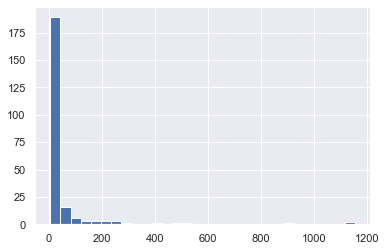

In [479]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

    
print('Number of counties with non-zero deaths')
print(sum([v > 0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [480]:
sum(max_deaths)

12403

In [481]:
max(max_deaths)

1153

In [482]:
np.quantile(max_deaths,.7)

1.0

### Clean data

In [483]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [419]:
method_keys = []

In [420]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [486]:
# target_day = np.array([1])
# # Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# # to a new column for test_df 
# # fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=np.array([1,2,3]))
# # fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# # Finds the names of all the methods
# method_keys = [c for c in df if 'predicted' in c]
# method_keys

In [487]:
# for days_ahead in [1, 2, 3]:
#      for method in ['exponential', 'shared_exponential', 'ensemble']:  
#         fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=np.array([days_ahead]))
        
#         if method == 'shared_exponential':
#             fit_and_predict(df,method='shared_exponential', 
#                             outcome=outcome_type, 
#                              mode='eval_mode',
#                              demographic_vars=very_important_vars,
#                              target_day=np.array([days_ahead]))
# method_keys = [c for c in df if 'predicted' in c]
# geo = ['countyFIPS', 'CountyNamew/StateAbbrev']

In [488]:
# method_keys = [c for c in df if 'predicted' in c]
# df_preds = df[method_keys + geo + ['deaths']]
# df_preds.to_pickle("multi_day_6.pkl")

## Ensemble predictions

In [658]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}

In [659]:
# import fit_and_predict
# for d in [1, 2, 3]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array([d]),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}'
#                                                    )

In [765]:
feat_transforms = defaultdict(lambda y: [lambda x: x]) 
# feat_transforms['deaths'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['cases'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]
# feat_transforms['neighbor_cases'] = [lambda x: np.log(x+1),lambda x: np.log(np.log(x+1)+1)]

feat_transforms['deaths'] = [lambda x: np.log(x+1)]
feat_transforms['cases'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_deaths'] =  [lambda x: np.log(x+1)]
feat_transforms['neighbor_cases'] =  [lambda x: np.log(x+1)]
default_values = defaultdict(lambda: 0) 

In [766]:

feat_transforms['neighbor_deaths']

[<function __main__.<lambda>(x)>]

In [767]:
shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,10)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['cases','neighbor_deaths','neighbor_cases'],time_series_default_values=default_values,scale=True)
# shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,8)),
#                            feat_transforms=feat_transforms,auxiliary_time_features=['cases'],time_series_default_values=default_values,scale=True)

shared_model = SharedModel(df=df,outcome=outcome_type,demographic_variables=[],mode='eval_mode',target_days=np.array(range(1,10)),
                           feat_transforms=feat_transforms,auxiliary_time_features=['neighbor_deaths'],time_series_default_values=default_values,scale=True)


In [768]:
shared_model.create_dataset()

In [769]:
shared_model.fit_model()


In [770]:
shared_model.predict()

In [771]:
shared_model.model.params

array([ 0.96585226, -0.04113699,  1.94894313])

In [118]:
advanced_model = {'model_type':'advanced_shared_model'}

In [424]:
# clear predictions
for m in method_keys:
    del df[m]
    
method_keys = [c for c in df if 'predicted' in c]
    

In [425]:
method_keys

[]

In [466]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#                                                       exponential, 
#                                                       demographics,
                                                      advanced_model,

                                                    
                                                    
                                                          linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d}_with_advanced',
                                                  verbose=True
                                                   ) 

--- Model Contributions ---
{'model_type': 'linear'}: 0.7011372287788115
{'model_type': 'advanced_shared_model'}: 0.29886277122118965


In [467]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#                                                       exponential, 
                                                           shared_exponential,
#                                                       demographics,
                                                      advanced_model,

                                                    
                                                    
                                                          linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d}_with_both'
                                                   ) 

In [468]:
import fit_and_predict
for d in [7]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(range(1, d+1)),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                  methods=[ 
#                                                       exponential, 
                                                           shared_exponential,
#                                                       demographics,
#                                                       advanced_model,

                                                          linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d}'
                                                   ) 

In [469]:
# import fit_and_predict
# for d in [4]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array(range(1, d+1)),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   methods=[ 
# #                                                       exponential, 
#                                                            shared_exponential,
# #                                                       demographics,

# #                                                           linear
#                                                          ],
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}_with_exponential'
#                                                    ) 

In [470]:
# Feature weights
# PopulationDensityperSqMile2010 : 0.004745182621539039
# Respiratory Mortality : -0.05173444687184794
# PopulationEstimate2018 : -0.046866686419304526
# #ICU_beds : -0.011788640479631832
# MedianAge2010 : 0.03579904251021662
# Smokers_Percentage : 0.00824343481343873
# DiabetesPercentage : 0.01833651602597799
# HeartDiseaseMortality : 0.030078534240604964
# #Hospitals : 0.07194365950227814
# log(deaths) : 0.983469697152724
# bias : 1.0144103433866933

In [471]:
method_keys = [c for c in df if 'predicted' in c]

In [472]:
# df = fit_and_predict.fit_and_predict_ensemble(df)

In [473]:
method_keys

['predicted_deaths_ensemble_7_with_advanced',
 'predicted_deaths_ensemble_7_with_both',
 'predicted_deaths_ensemble_7']

In [474]:
# df['predicted_deaths_ensemble_3_with_cases'] = shared_model.predictions
# method_keys.append('predicted_deaths_ensemble_3_with_cases')


## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [475]:


# TODO: add average rank as metric

In [476]:
# Computes the mse in log space and non-log space for all columns

In [477]:
def l1(arr1,arr2,norm=True):
    """
    arr2 ground truth
    arr1 predictions
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf

In [478]:

# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold)]] # * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_deaths_ensemble_7_with_advanced
0.12884047078040245
Log scale MSE for predicted_deaths_ensemble_7_with_both
0.1257844346863944
Log scale MSE for predicted_deaths_ensemble_7
0.165744423449473


In [479]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_deaths_ensemble_7_with_advanced
0.08583724441689906
Log scale l1 for predicted_deaths_ensemble_7_with_both
0.08976753528655028
Log scale l1 for predicted_deaths_ensemble_7
0.09739259178566029


In [480]:
#alpha = .01, 1600.2934499171229

In [481]:
# alpha = 0, 1542.4338963814796

In [482]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_deaths_ensemble_7_with_advanced
1637.4987796461705
Raw MSE for predicted_deaths_ensemble_7_with_both
3320.4761140513156
Raw MSE for predicted_deaths_ensemble_7
3481.269392202397


In [483]:
#[alpha = .01, 1122.4187100081517]
#[alpha = .001, 1103.7477272612207]
#[alpha = 0,1101.7658699463036]

In [484]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_deaths_ensemble_7_with_advanced
0.2841729431325794
Raw l1 for predicted_deaths_ensemble_7_with_both
0.3276482194966536
Raw l1 for predicted_deaths_ensemble_7
0.3170102978415443


In [491]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds,norm=False))

Raw l1 for predicted_deaths_ensemble_7_with_advanced
16.395977793953495
Raw l1 for predicted_deaths_ensemble_7_with_both
20.846320444400828
Raw l1 for predicted_deaths_ensemble_7
22.90637339537163


### Plot residuals

In [492]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

In [493]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

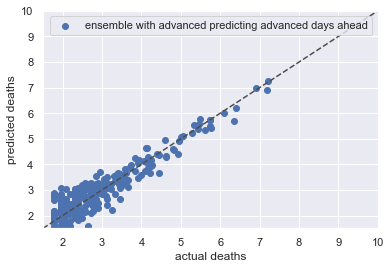

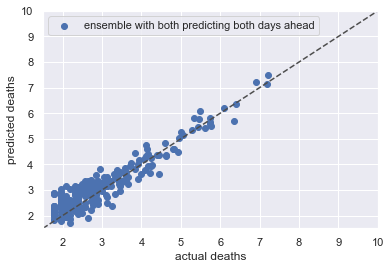

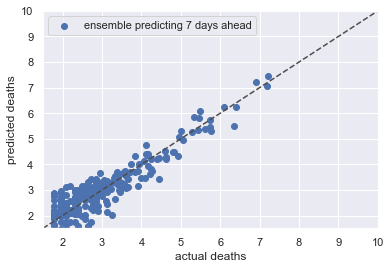

In [494]:
# Make log plots:
bounds = [1.5, 10]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

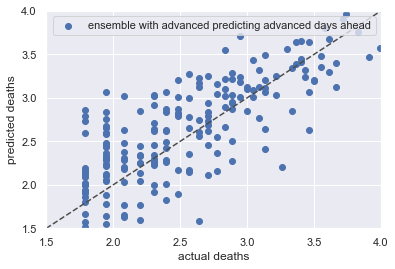

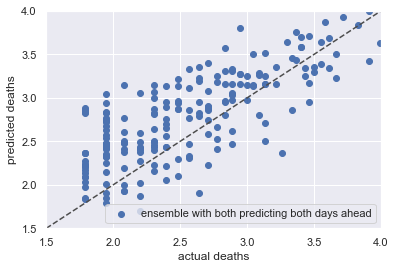

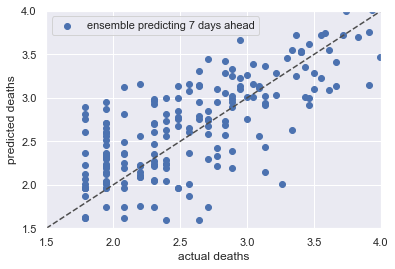

In [495]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

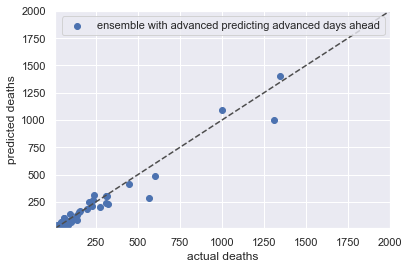

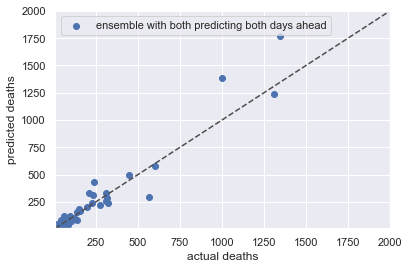

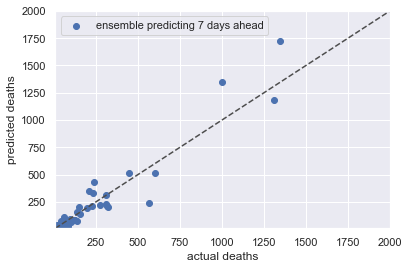

In [496]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [10,2000]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

### Graph Visualizations

In [497]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [498]:
def plot_log(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    values = [np.log(v+1) for v in list(row[outcome_type])[start_point:]]

    sns.lineplot(list(range(len(values))),values, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [499]:
def plot_ratio(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    prev = 5
    ratios = []
    values = list(row[outcome_type])[start_point:]
    for i in range(len(values)):
        ratios.append((values[i]+5)/prev)
        prev = values[i]+5
    
    sns.lineplot(list(range(len(values))),ratios, label=outcome_type)

    
        
    
    


    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [500]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [501]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

Queens in NY


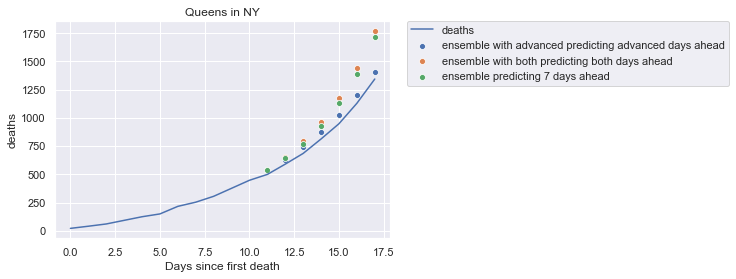

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 20553.6
Respiratory Mortality: 24.13
PopulationEstimate2018: 2278906.0
#ICU_beds: 129
MedianAge2010: 37.2
Smokers_Percentage: 12.42777748
DiabetesPercentage: 10.2
HeartDiseaseMortality: 180.0
#Hospitals: 6


Kings in NY


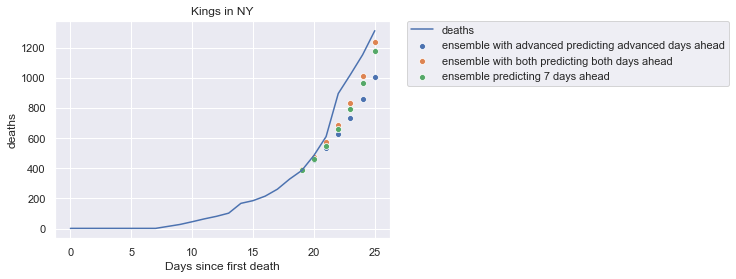

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 35369.2
Respiratory Mortality: 23.05
PopulationEstimate2018: 2582830.0
#ICU_beds: 318
MedianAge2010: 34.1
Smokers_Percentage: 13.840801998
DiabetesPercentage: 9.7
HeartDiseaseMortality: 195.8
#Hospitals: 12


Bronx in NY


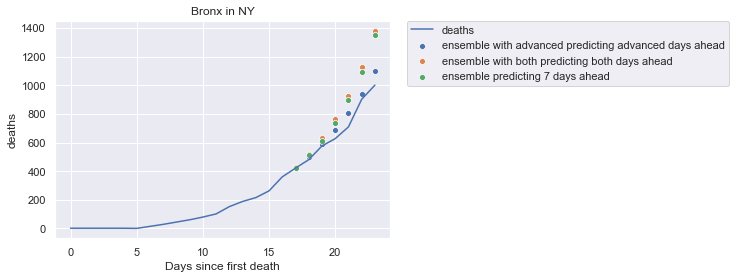

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 32903.3
Respiratory Mortality: 31.58
PopulationEstimate2018: 1432132.0
#ICU_beds: 270
MedianAge2010: 32.8
Smokers_Percentage: 15.921168722
DiabetesPercentage: 12.3
HeartDiseaseMortality: 201.3
#Hospitals: 6


New York in NY


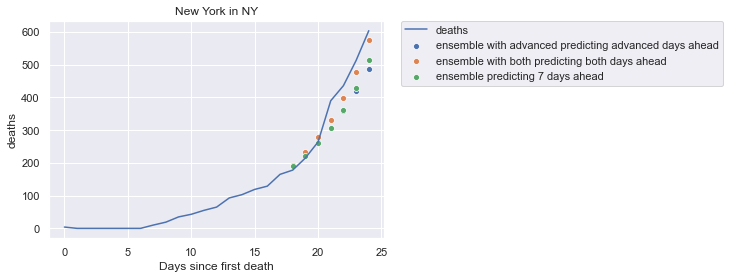

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 69468.4
Respiratory Mortality: 23.47
PopulationEstimate2018: 1628701.0
#ICU_beds: 761
MedianAge2010: 36.4
Smokers_Percentage: 12.41823421
DiabetesPercentage: 6.5
HeartDiseaseMortality: 143.5
#Hospitals: 12


Nassau in NY


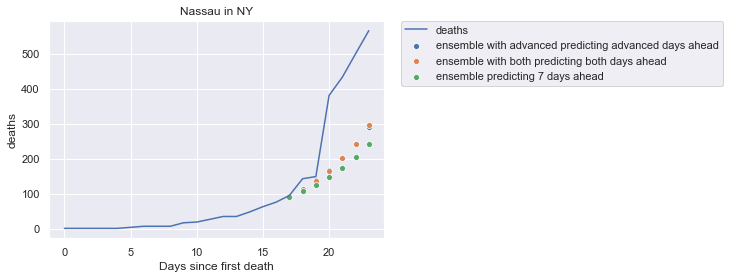

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 4704.8
Respiratory Mortality: 29.03
PopulationEstimate2018: 1358343.0
#ICU_beds: 461
MedianAge2010: 41.1
Smokers_Percentage: 11.225364644
DiabetesPercentage: 7.2
HeartDiseaseMortality: 188.2
#Hospitals: 10


Wayne in MI


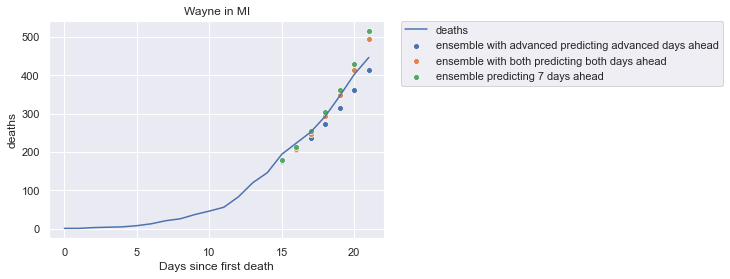

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2974.4
Respiratory Mortality: 53.48
PopulationEstimate2018: 1753893.0
#ICU_beds: 586
MedianAge2010: 37.3
Smokers_Percentage: 21.055529729
DiabetesPercentage: 10.3
HeartDiseaseMortality: 259.2
#Hospitals: 14


Suffolk in NY


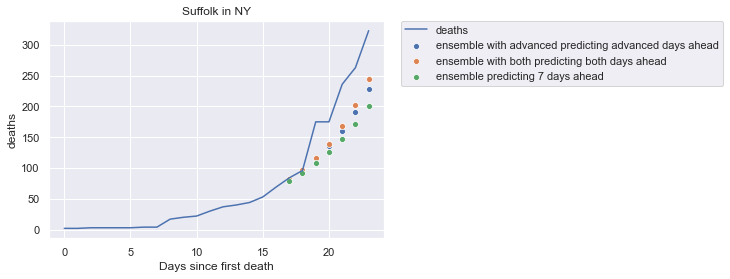

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1637.4
Respiratory Mortality: 38.59
PopulationEstimate2018: 1481093.0
#ICU_beds: 281
MedianAge2010: 39.8
Smokers_Percentage: 12.625481467
DiabetesPercentage: 6.8
HeartDiseaseMortality: 181.8
#Hospitals: 10


Westchester in NY


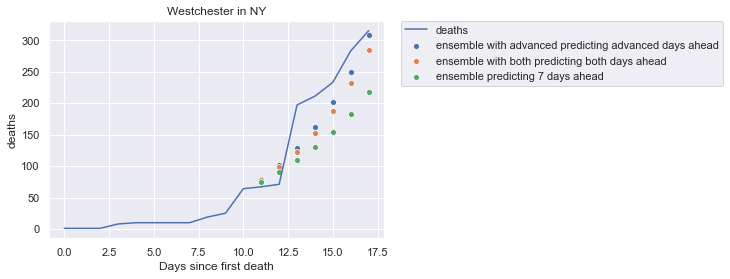

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2204.7
Respiratory Mortality: 31.82
PopulationEstimate2018: 967612.0
#ICU_beds: 179
MedianAge2010: 40.0
Smokers_Percentage: 11.37154602
DiabetesPercentage: 6.4
HeartDiseaseMortality: 146.8
#Hospitals: 9


Bergen in NJ


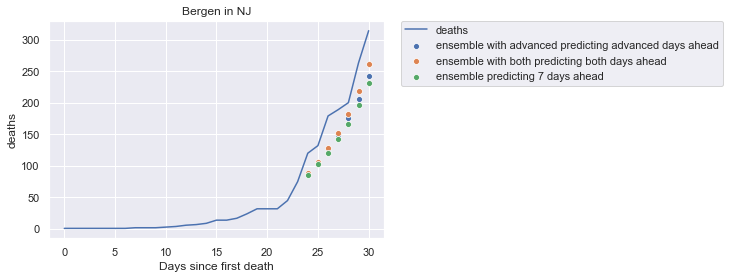

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3884.5
Respiratory Mortality: 29.49
PopulationEstimate2018: 936692.0
#ICU_beds: 147
MedianAge2010: 41.1
Smokers_Percentage: 11.410986988
DiabetesPercentage: 6.8
HeartDiseaseMortality: 140.1
#Hospitals: 6


Cook in IL


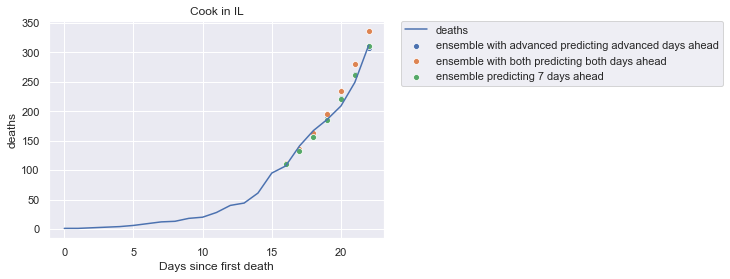

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 5495.1
Respiratory Mortality: 41.02
PopulationEstimate2018: 5180493.0
#ICU_beds: 1606
MedianAge2010: 35.3
Smokers_Percentage: 13.776183162
DiabetesPercentage: 9
HeartDiseaseMortality: 175.1
#Hospitals: 46


Essex in NJ


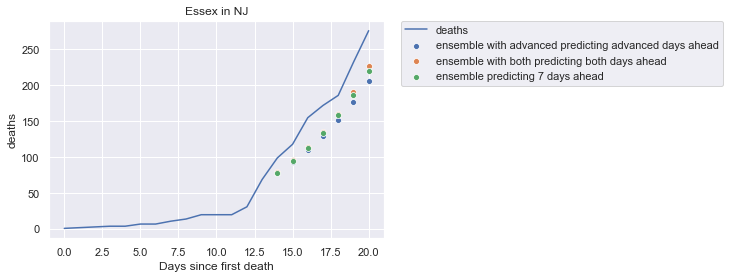

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 6211.5
Respiratory Mortality: 33.96
PopulationEstimate2018: 799767.0
#ICU_beds: 267
MedianAge2010: 36.4
Smokers_Percentage: 14.235389268
DiabetesPercentage: 9.9
HeartDiseaseMortality: 169.8
#Hospitals: 7


King in WA


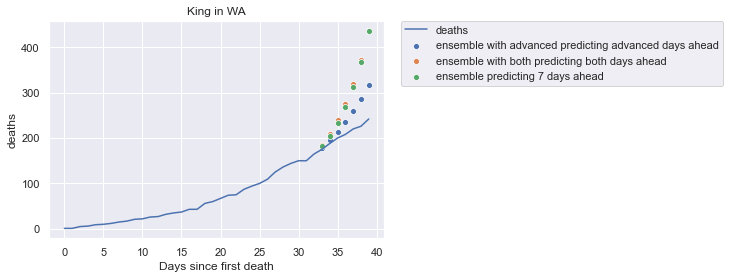

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 912.9
Respiratory Mortality: 37.33
PopulationEstimate2018: 2233163.0
#ICU_beds: 450
MedianAge2010: 37.1
Smokers_Percentage: 8.8150454593
DiabetesPercentage: 7.1
HeartDiseaseMortality: 118.9
#Hospitals: 17


Oakland in MI


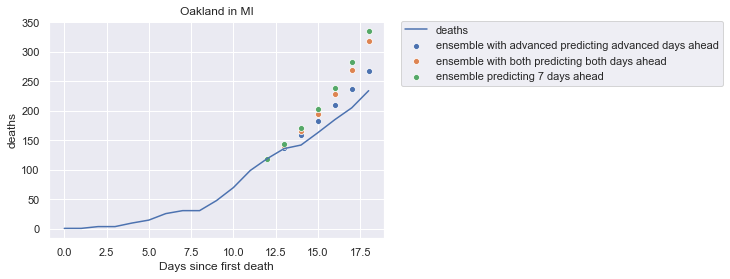

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1385.8
Respiratory Mortality: 46.33
PopulationEstimate2018: 1259201.0
#ICU_beds: 409
MedianAge2010: 40.2
Smokers_Percentage: 12.308266081
DiabetesPercentage: 7.7
HeartDiseaseMortality: 181.4
#Hospitals: 12


Richmond in NY


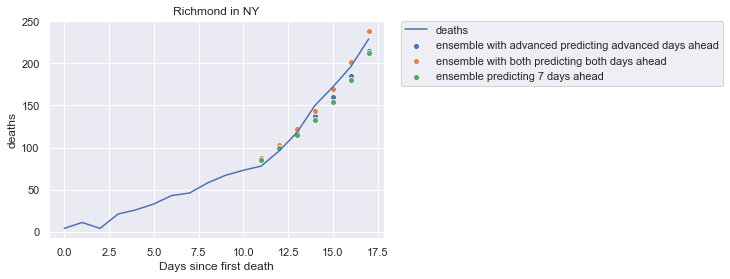

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 8030.3
Respiratory Mortality: 34.76
PopulationEstimate2018: 476179.0
#ICU_beds: 114
MedianAge2010: 38.4
Smokers_Percentage: 15.373417772
DiabetesPercentage: 9.6
HeartDiseaseMortality: 239.6
#Hospitals: 2


Orleans in LA


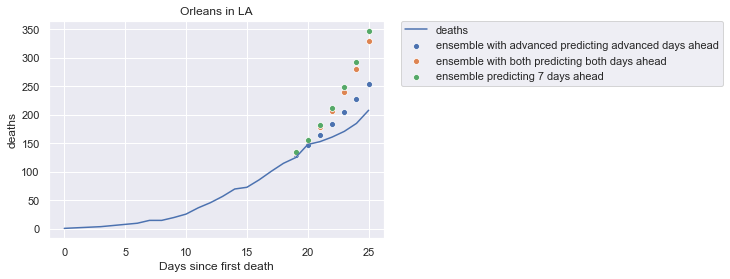

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2029.4
Respiratory Mortality: 39.42
PopulationEstimate2018: 391006.0
#ICU_beds: 111
MedianAge2010: 34.6
Smokers_Percentage: 22.609624129
DiabetesPercentage: 10.3
HeartDiseaseMortality: 189.7
#Hospitals: 5


Los Angeles in CA


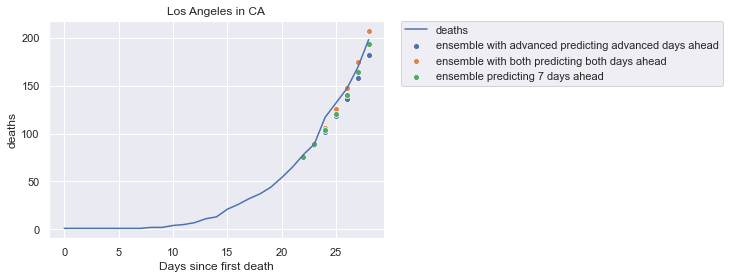

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2419.6
Respiratory Mortality: 34.94
PopulationEstimate2018: 10105518.0
#ICU_beds: 2126
MedianAge2010: 34.8
Smokers_Percentage: 10.847678109
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.8
#Hospitals: 76


Fairfield in CT


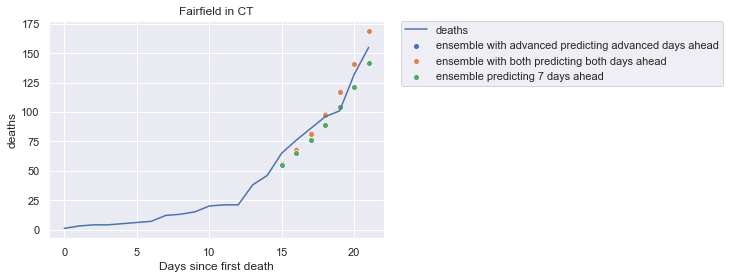

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1467.2
Respiratory Mortality: 34.15
PopulationEstimate2018: 943823.0
#ICU_beds: 173
MedianAge2010: 39.5
Smokers_Percentage: 10.157896011
DiabetesPercentage: 6.4
HeartDiseaseMortality: 137.1
#Hospitals: 6


Jefferson in LA


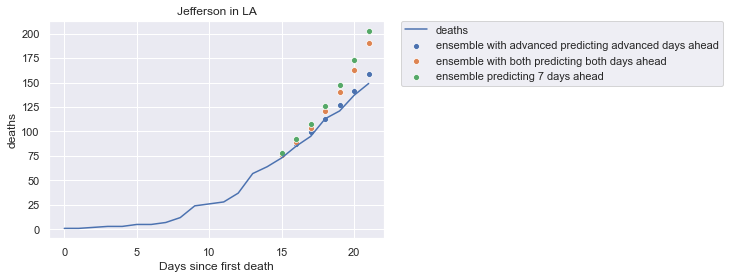

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1463.1
Respiratory Mortality: 53.68
PopulationEstimate2018: 434051.0
#ICU_beds: 215
MedianAge2010: 38.4
Smokers_Percentage: 18.743669593
DiabetesPercentage: 12.7
HeartDiseaseMortality: 178.7
#Hospitals: 5


Macomb in MI


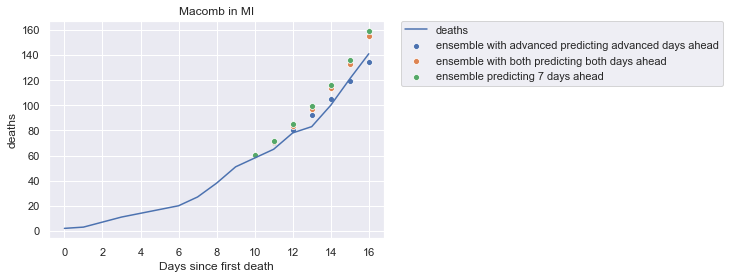

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1754.9
Respiratory Mortality: 53.07
PopulationEstimate2018: 874759.0
#ICU_beds: 122
MedianAge2010: 39.9
Smokers_Percentage: 18.558096157
DiabetesPercentage: 9.5
HeartDiseaseMortality: 196.6
#Hospitals: 4


Middlesex in NJ


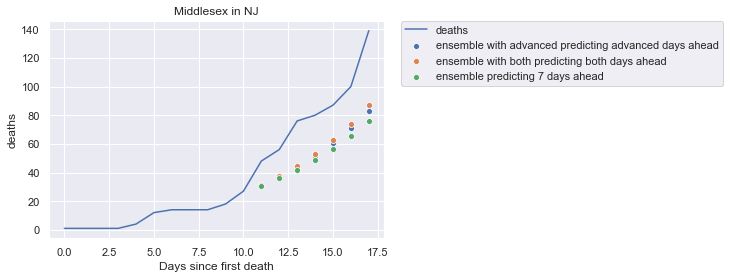

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2621.6
Respiratory Mortality: 35.07
PopulationEstimate2018: 829685.0
#ICU_beds: 185
MedianAge2010: 37.2
Smokers_Percentage: 10.970467888
DiabetesPercentage: 9.7
HeartDiseaseMortality: 154.3
#Hospitals: 5


Union in NJ


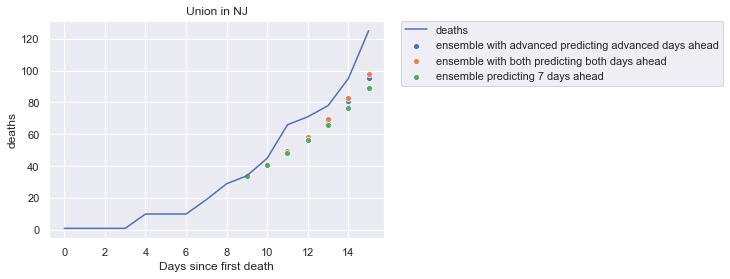

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 5216.1
Respiratory Mortality: 35.43
PopulationEstimate2018: 558067.0
#ICU_beds: 80
MedianAge2010: 38.0
Smokers_Percentage: 13.07573586
DiabetesPercentage: 7.5
HeartDiseaseMortality: 157.9
#Hospitals: 3


Hudson in NJ


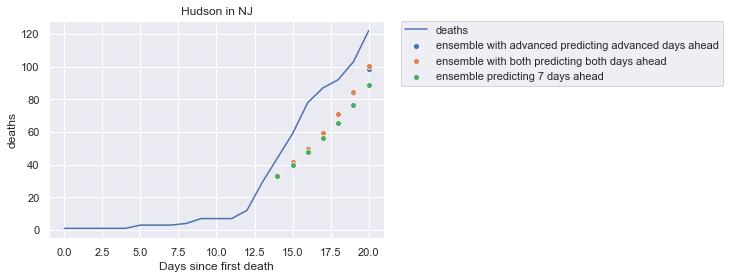

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 13731.4
Respiratory Mortality: 34.89
PopulationEstimate2018: 676061.0
#ICU_beds: 105
MedianAge2010: 34.2
Smokers_Percentage: 15.382038155
DiabetesPercentage: 8.2
HeartDiseaseMortality: 157.6
#Hospitals: 6


Morris in NJ


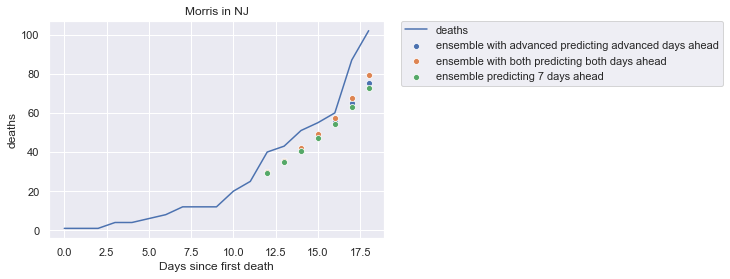

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1069.8
Respiratory Mortality: 34.49
PopulationEstimate2018: 494228.0
#ICU_beds: 91
MedianAge2010: 41.3
Smokers_Percentage: 12.111935176
DiabetesPercentage: 6.3
HeartDiseaseMortality: 143.5
#Hospitals: 3


Ocean in NJ


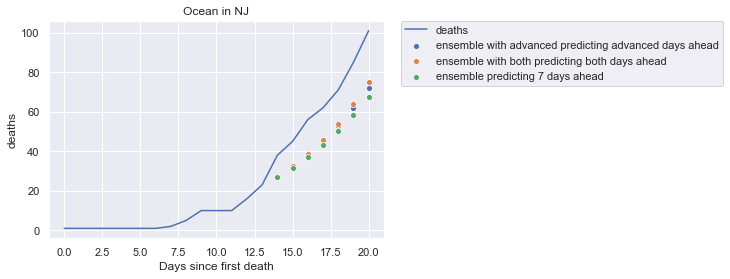

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 917.0
Respiratory Mortality: 43.02
PopulationEstimate2018: 601651.0
#ICU_beds: 106
MedianAge2010: 42.6
Smokers_Percentage: 14.443273724
DiabetesPercentage: 8.3
HeartDiseaseMortality: 202.7
#Hospitals: 4


Rockland in NY


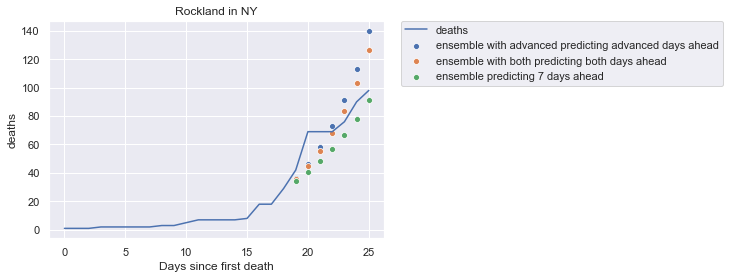

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1796.0
Respiratory Mortality: 33.58
PopulationEstimate2018: 325695.0
#ICU_beds: 39
MedianAge2010: 36.7
Smokers_Percentage: 12.165288495
DiabetesPercentage: 6.9
HeartDiseaseMortality: 150.9
#Hospitals: 3


Philadelphia in PA


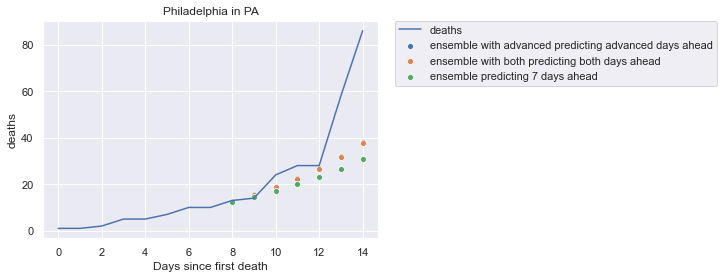

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 11379.5
Respiratory Mortality: 50.06
PopulationEstimate2018: 1584138.0
#ICU_beds: 528
MedianAge2010: 33.5
Smokers_Percentage: 20.614249405
DiabetesPercentage: 10.4
HeartDiseaseMortality: 213.7
#Hospitals: 15


Monmouth in NJ


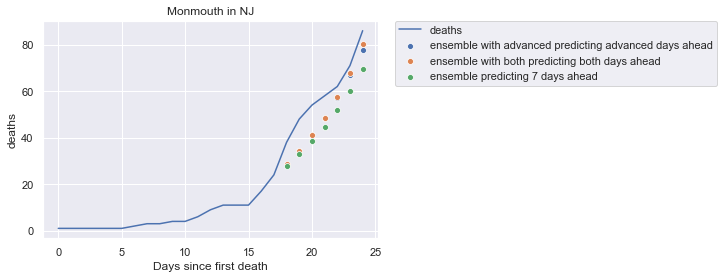

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1344.7
Respiratory Mortality: 44.08
PopulationEstimate2018: 621354.0
#ICU_beds: 152
MedianAge2010: 41.3
Smokers_Percentage: 13.360452416
DiabetesPercentage: 7.5
HeartDiseaseMortality: 159.1
#Hospitals: 5


Middlesex in MA


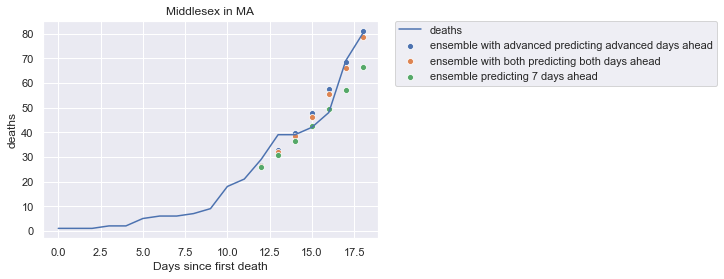

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1837.9
Respiratory Mortality: 36.99
PopulationEstimate2018: 1614714.0
#ICU_beds: 216
MedianAge2010: 38.5
Smokers_Percentage: 9.9544431395
DiabetesPercentage: 6.8
HeartDiseaseMortality: 121.8
#Hospitals: 11


Passaic in NJ


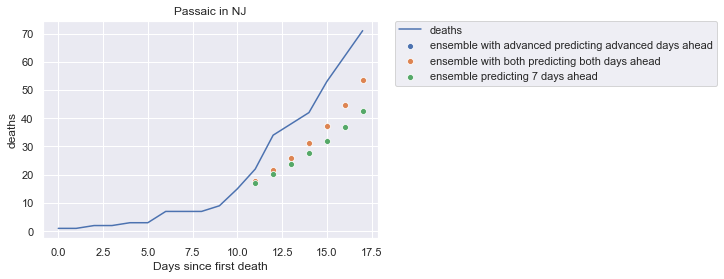

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2715.3
Respiratory Mortality: 40.21
PopulationEstimate2018: 503310.0
#ICU_beds: 97
MedianAge2010: 36.1
Smokers_Percentage: 13.782069143
DiabetesPercentage: 7.8
HeartDiseaseMortality: 167.4
#Hospitals: 2


New Haven in CT


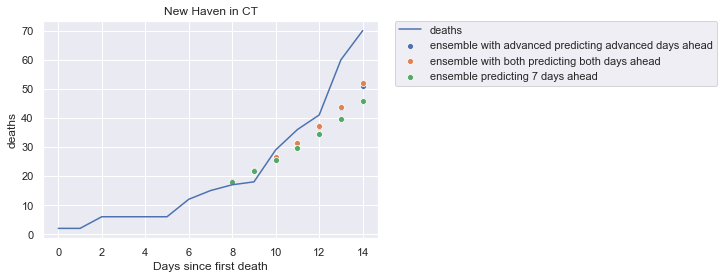

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1426.8
Respiratory Mortality: 45.49
PopulationEstimate2018: 857620.0
#ICU_beds: 186
MedianAge2010: 39.3
Smokers_Percentage: 12.843951967
DiabetesPercentage: 8.6
HeartDiseaseMortality: 148.4
#Hospitals: 8


Palm Beach in FL


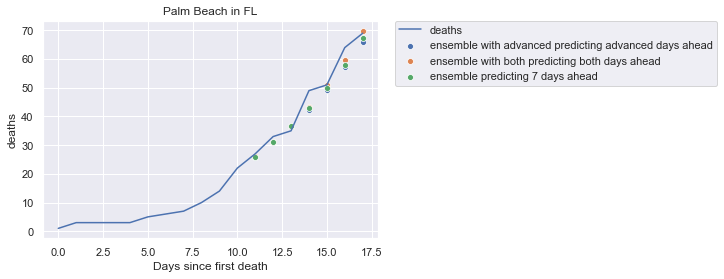

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 670.2
Respiratory Mortality: 32.77
PopulationEstimate2018: 1485941.0
#ICU_beds: 401
MedianAge2010: 43.5
Smokers_Percentage: 15.916105958
DiabetesPercentage: 7.7
HeartDiseaseMortality: 123.6
#Hospitals: 12


Hartford in CT


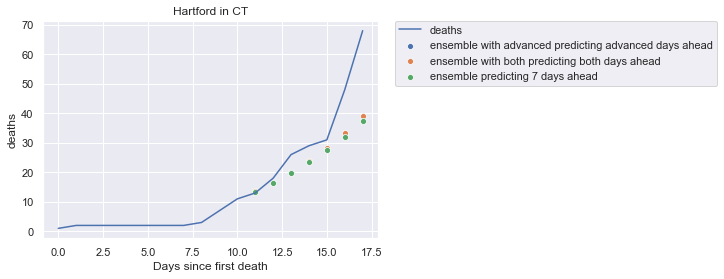

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1216.2
Respiratory Mortality: 44.55
PopulationEstimate2018: 892697.0
#ICU_beds: 216
MedianAge2010: 39.9
Smokers_Percentage: 11.356248016
DiabetesPercentage: 8.6
HeartDiseaseMortality: 149.3
#Hospitals: 7


Clark in NV


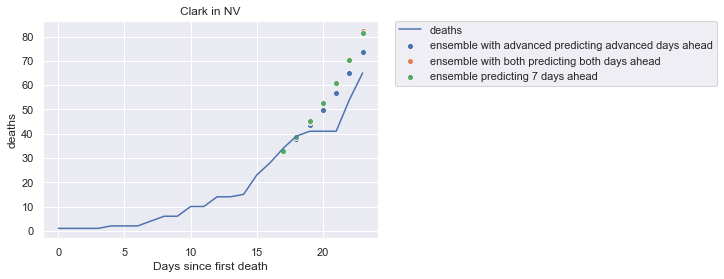

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 247.3
Respiratory Mortality: 63.75
PopulationEstimate2018: 2231647.0
#ICU_beds: 535
MedianAge2010: 35.5
Smokers_Percentage: 16.979704666
DiabetesPercentage: 10
HeartDiseaseMortality: 204.3
#Hospitals: 19


Hampden in MA


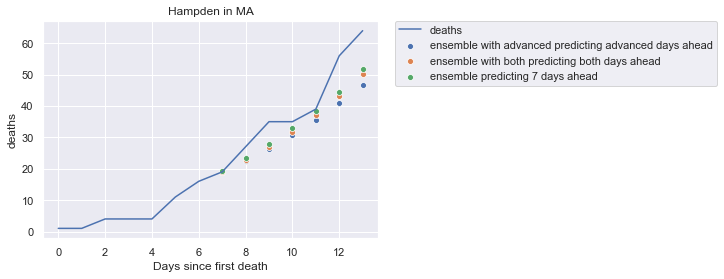

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 751.0
Respiratory Mortality: 49.07
PopulationEstimate2018: 470406.0
#ICU_beds: 119
MedianAge2010: 38.6
Smokers_Percentage: 15.440525252
DiabetesPercentage: 9.5
HeartDiseaseMortality: 150.8
#Hospitals: 5


Orange in NY


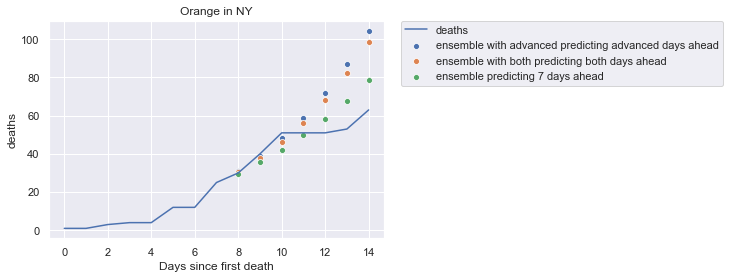

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 459.3
Respiratory Mortality: 52.02
PopulationEstimate2018: 381951.0
#ICU_beds: 76
MedianAge2010: 36.6
Smokers_Percentage: 15.142023205
DiabetesPercentage: 8.6
HeartDiseaseMortality: 180.8
#Hospitals: 4


Snohomish in WA


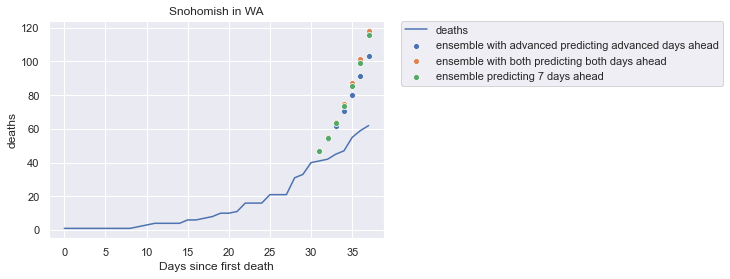

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 341.8
Respiratory Mortality: 50.18
PopulationEstimate2018: 814901.0
#ICU_beds: 72
MedianAge2010: 37.1
Smokers_Percentage: 12.962308599
DiabetesPercentage: 7.7
HeartDiseaseMortality: 131.9
#Hospitals: 4


Dougherty in GA


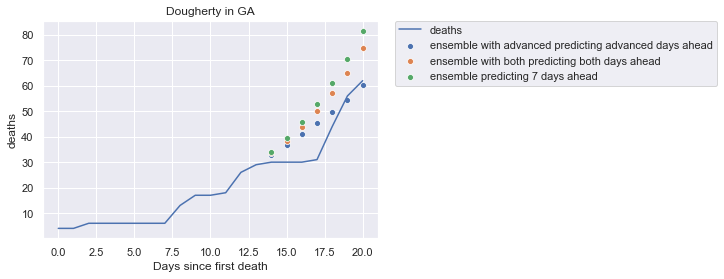

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 287.7
Respiratory Mortality: 66.83
PopulationEstimate2018: 91243.0
#ICU_beds: 50
MedianAge2010: 33.2
Smokers_Percentage: 21.607553194
DiabetesPercentage: 13.8
HeartDiseaseMortality: 178.8
#Hospitals: 1


Broward in FL


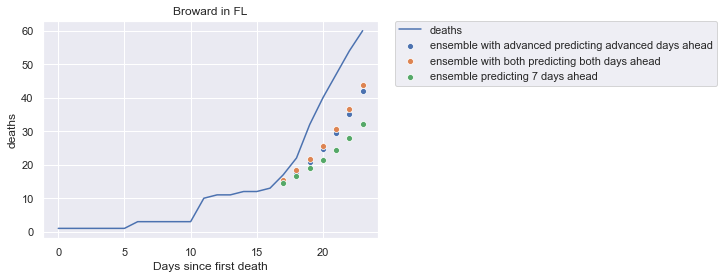

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1444.9
Respiratory Mortality: 39.77
PopulationEstimate2018: 1951260.0
#ICU_beds: 587
MedianAge2010: 39.7
Smokers_Percentage: 14.593792551
DiabetesPercentage: 8.1
HeartDiseaseMortality: 146.9
#Hospitals: 14


Marion in IN


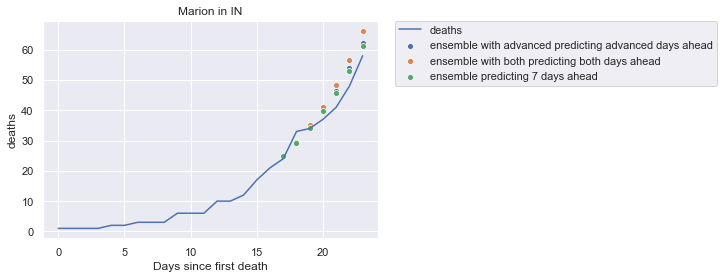

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2279.6
Respiratory Mortality: 78.21
PopulationEstimate2018: 954670.0
#ICU_beds: 526
MedianAge2010: 33.9
Smokers_Percentage: 19.241619979
DiabetesPercentage: 11.6
HeartDiseaseMortality: 183.2
#Hospitals: 9


Milwaukee in WI


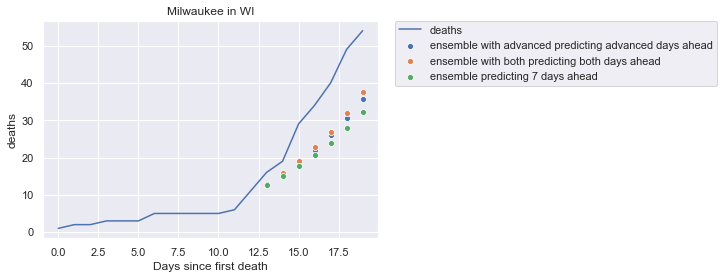

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3926.0
Respiratory Mortality: 53.45
PopulationEstimate2018: 948201.0
#ICU_beds: 381
MedianAge2010: 33.6
Smokers_Percentage: 17.817309912
DiabetesPercentage: 10.1
HeartDiseaseMortality: 182.6
#Hospitals: 8


Essex in MA


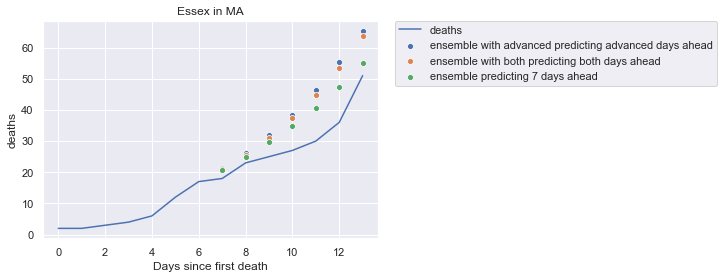

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1508.8
Respiratory Mortality: 44.01
PopulationEstimate2018: 790638.0
#ICU_beds: 98
MedianAge2010: 40.4
Smokers_Percentage: 11.74006476
DiabetesPercentage: 8.3
HeartDiseaseMortality: 135.7
#Hospitals: 5


Suffolk in MA


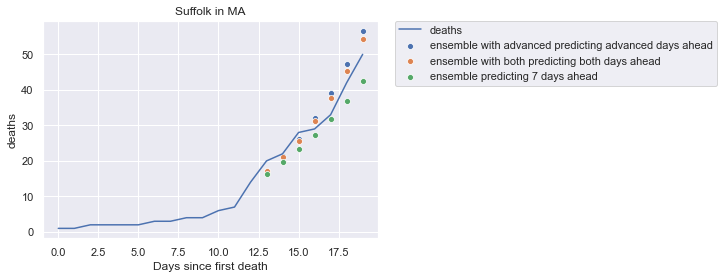

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 12415.7
Respiratory Mortality: 39.94
PopulationEstimate2018: 807252.0
#ICU_beds: 447
MedianAge2010: 31.5
Smokers_Percentage: 14.475410922
DiabetesPercentage: 9.1
HeartDiseaseMortality: 125.4
#Hospitals: 10


Miami-Dade in FL


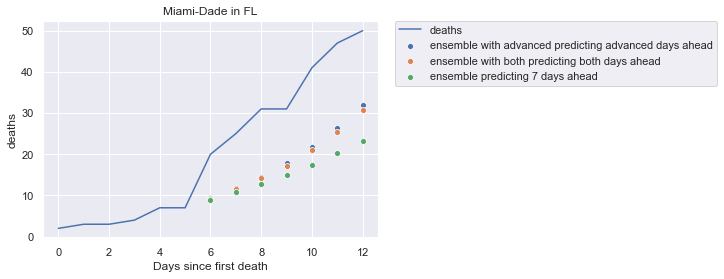

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1315.5
Respiratory Mortality: 33.65
PopulationEstimate2018: 2761581.0
#ICU_beds: 593
MedianAge2010: 38.2
Smokers_Percentage: 16.479410011
DiabetesPercentage: 6.7
HeartDiseaseMortality: 152.4
#Hospitals: 17


Somerset in NJ


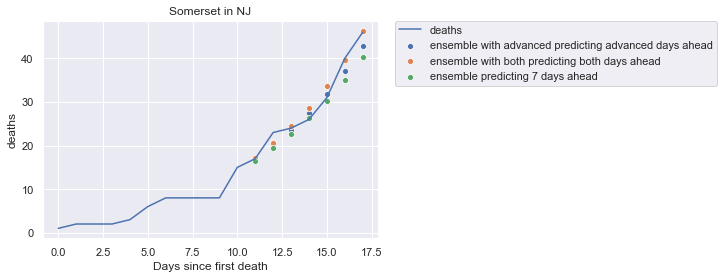

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1071.7
Respiratory Mortality: 37.00
PopulationEstimate2018: 331164.0
#ICU_beds: 28
MedianAge2010: 40.2
Smokers_Percentage: 10.843821151
DiabetesPercentage: 6.2
HeartDiseaseMortality: 136.2
#Hospitals: 1


Santa Clara in CA


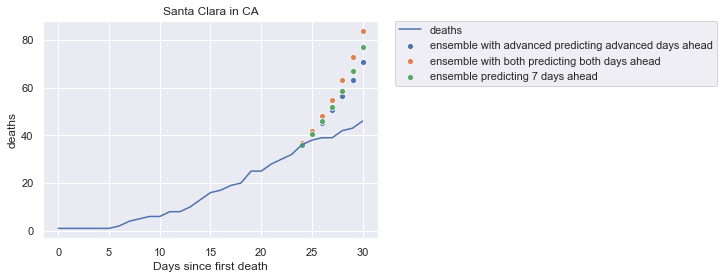

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1381.0
Respiratory Mortality: 29.68
PopulationEstimate2018: 1937570.0
#ICU_beds: 313
MedianAge2010: 36.2
Smokers_Percentage: 8.2690140125
DiabetesPercentage: 7.3
HeartDiseaseMortality: 104.2
#Hospitals: 9


Fulton in GA


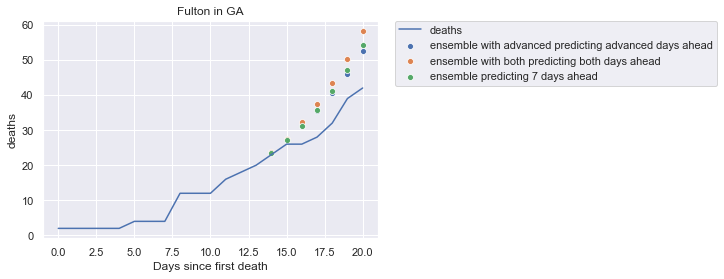

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1748.1
Respiratory Mortality: 40.61
PopulationEstimate2018: 1050114.0
#ICU_beds: 538
MedianAge2010: 34.2
Smokers_Percentage: 14.925509463
DiabetesPercentage: 8.3
HeartDiseaseMortality: 157.6
#Hospitals: 7


Norfolk in MA


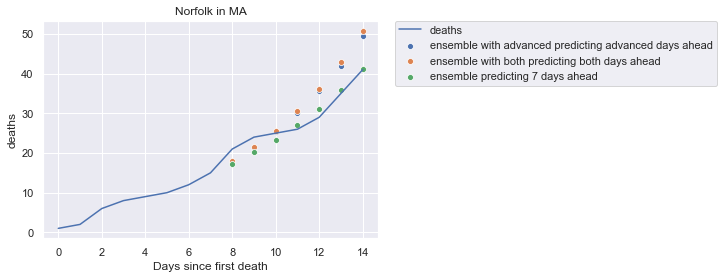

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1693.6
Respiratory Mortality: 39.61
PopulationEstimate2018: 705388.0
#ICU_beds: 59
MedianAge2010: 40.7
Smokers_Percentage: 12.238980283
DiabetesPercentage: 7.3
HeartDiseaseMortality: 130.5
#Hospitals: 4


Genesee in MI


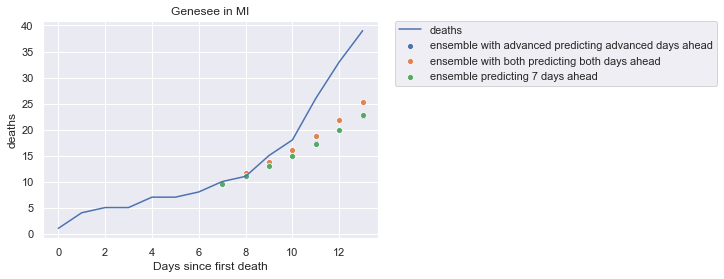

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 668.5
Respiratory Mortality: 66.89
PopulationEstimate2018: 406892.0
#ICU_beds: 151
MedianAge2010: 38.5
Smokers_Percentage: 18.986887756
DiabetesPercentage: 11.6
HeartDiseaseMortality: 227.3
#Hospitals: 3


Erie in NY


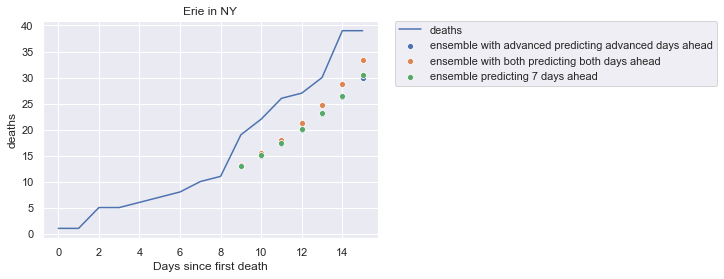

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 881.4
Respiratory Mortality: 48.21
PopulationEstimate2018: 919719.0
#ICU_beds: 262
MedianAge2010: 40.4
Smokers_Percentage: 17.253724261
DiabetesPercentage: 9.6
HeartDiseaseMortality: 180.9
#Hospitals: 6


Maricopa in AZ


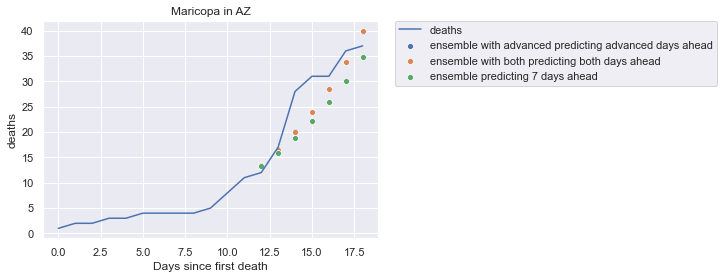

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 414.9
Respiratory Mortality: 51.21
PopulationEstimate2018: 4410824.0
#ICU_beds: 1004
MedianAge2010: 34.6
Smokers_Percentage: 13.686398251
DiabetesPercentage: 8.2
HeartDiseaseMortality: 130.3
#Hospitals: 34


Montgomery in PA


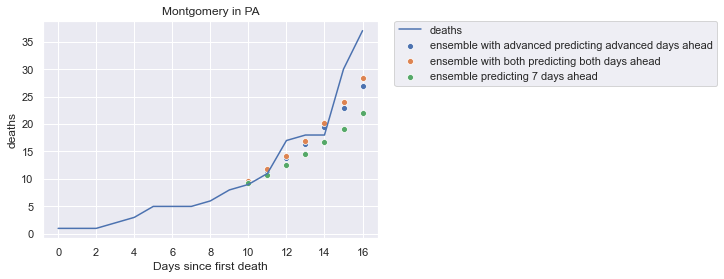

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1655.9
Respiratory Mortality: 43.32
PopulationEstimate2018: 828604.0
#ICU_beds: 215
MedianAge2010: 40.6
Smokers_Percentage: 13.194677885
DiabetesPercentage: 7
HeartDiseaseMortality: 142.7
#Hospitals: 11


San Diego in CA


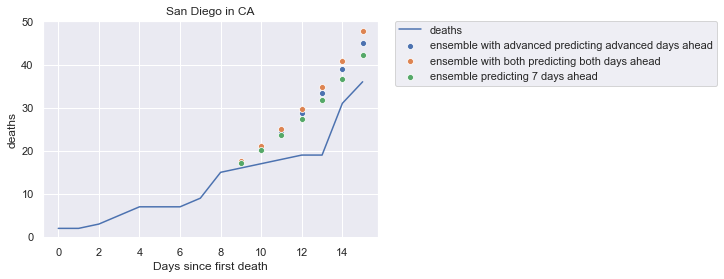

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 735.8
Respiratory Mortality: 38.91
PopulationEstimate2018: 3343364.0
#ICU_beds: 570
MedianAge2010: 34.6
Smokers_Percentage: 10.753175291
DiabetesPercentage: 6.9
HeartDiseaseMortality: 132.4
#Hospitals: 15


St. John the Baptist in LA


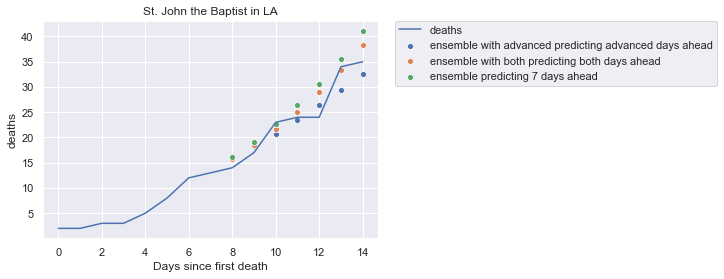

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 215.5
Respiratory Mortality: 47.73
PopulationEstimate2018: 43184.0
#ICU_beds: 0
MedianAge2010: 35.5
Smokers_Percentage: 20.516015542
DiabetesPercentage: 9
HeartDiseaseMortality: 229.3
#Hospitals: 0


Will in IL


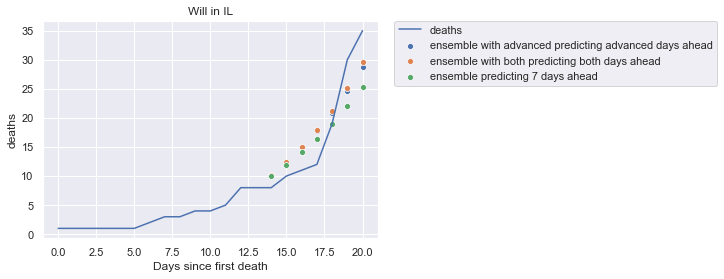

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 809.6
Respiratory Mortality: 45.10
PopulationEstimate2018: 692310.0
#ICU_beds: 92
MedianAge2010: 35.4
Smokers_Percentage: 13.070465481
DiabetesPercentage: 8.9
HeartDiseaseMortality: 167.0
#Hospitals: 3


East Baton Rouge in LA


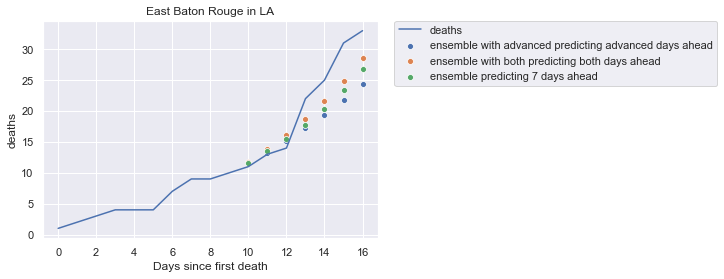

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 966.6
Respiratory Mortality: 49.50
PopulationEstimate2018: 440956.0
#ICU_beds: 124
MedianAge2010: 32.6
Smokers_Percentage: 18.269947005
DiabetesPercentage: 11.3
HeartDiseaseMortality: 216.4
#Hospitals: 7


Denver in CO


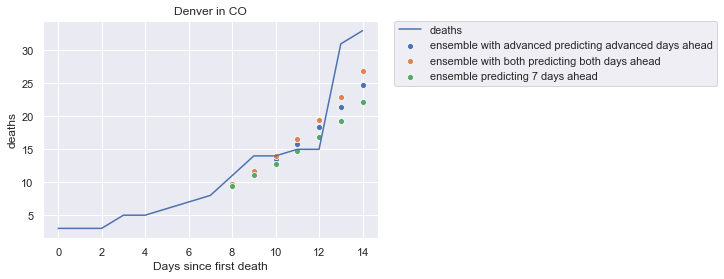

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3922.6
Respiratory Mortality: 57.93
PopulationEstimate2018: 716492.0
#ICU_beds: 227
MedianAge2010: 33.7
Smokers_Percentage: 14.664503351
DiabetesPercentage: 5.7
HeartDiseaseMortality: 146.5
#Hospitals: 6


Riverside in CA


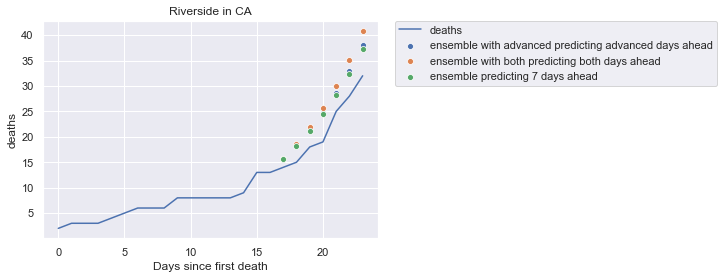

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 303.8
Respiratory Mortality: 50.72
PopulationEstimate2018: 2450758.0
#ICU_beds: 351
MedianAge2010: 33.7
Smokers_Percentage: 12.499944322
DiabetesPercentage: 8.7
HeartDiseaseMortality: 167.8
#Hospitals: 16


Prince George's in MD


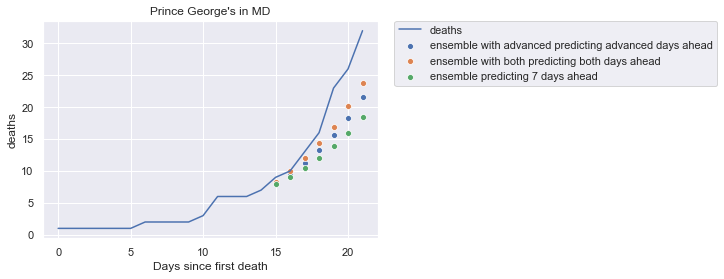

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1788.8
Respiratory Mortality: 26.31
PopulationEstimate2018: 909308.0
#ICU_beds: 89
MedianAge2010: 34.9
Smokers_Percentage: 11.97912293
DiabetesPercentage: 12.1
HeartDiseaseMortality: 172.2
#Hospitals: 5


Henrico in VA


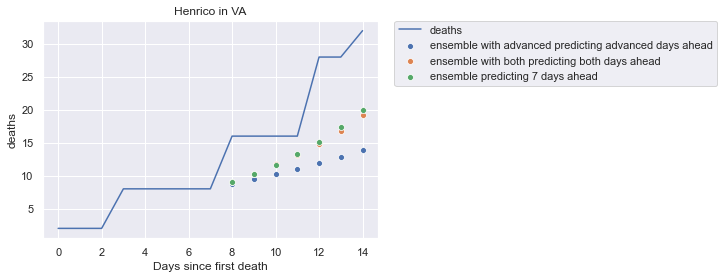

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1313.4
Respiratory Mortality: 51.50
PopulationEstimate2018: 329261.0
#ICU_beds: 53
MedianAge2010: 37.5
Smokers_Percentage: 15.165087834
DiabetesPercentage: 8.5
HeartDiseaseMortality: 155.3
#Hospitals: 1


Jefferson in KY


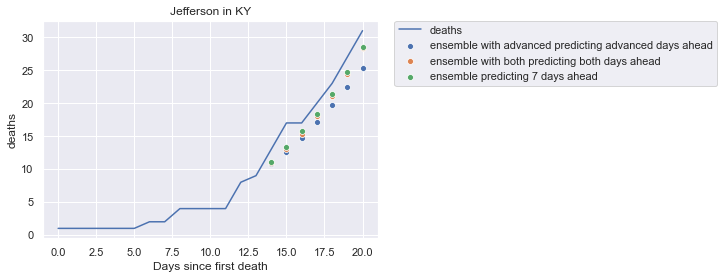

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1948.1
Respiratory Mortality: 66.47
PopulationEstimate2018: 770517.0
#ICU_beds: 366
MedianAge2010: 37.9
Smokers_Percentage: 19.826956296
DiabetesPercentage: 10.9
HeartDiseaseMortality: 168.4
#Hospitals: 4


Plymouth in MA


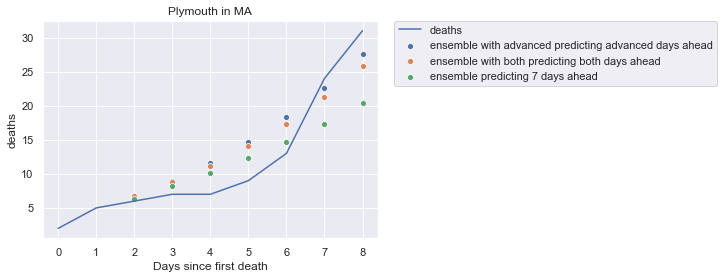

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 750.9
Respiratory Mortality: 50.92
PopulationEstimate2018: 518132.0
#ICU_beds: 47
MedianAge2010: 41.1
Smokers_Percentage: 14.512457326
DiabetesPercentage: 9
HeartDiseaseMortality: 149.5
#Hospitals: 3


El Paso in CO


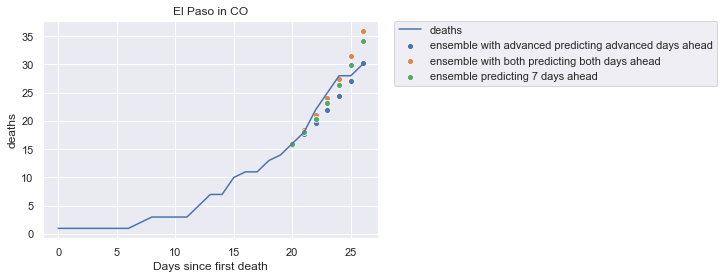

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 292.6
Respiratory Mortality: 58.05
PopulationEstimate2018: 713856.0
#ICU_beds: 95
MedianAge2010: 34.1
Smokers_Percentage: 14.264909913
DiabetesPercentage: 6.5
HeartDiseaseMortality: 135.6
#Hospitals: 3


DuPage in IL


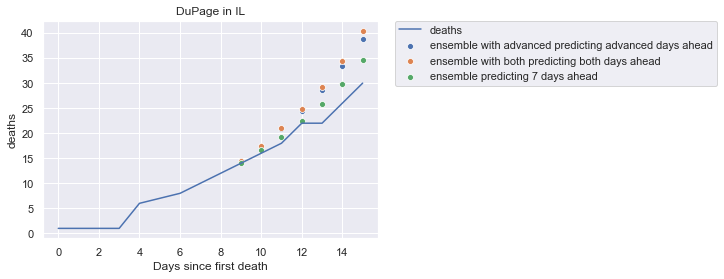

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2799.8
Respiratory Mortality: 40.66
PopulationEstimate2018: 928589.0
#ICU_beds: 257
MedianAge2010: 38.2
Smokers_Percentage: 12.257496254
DiabetesPercentage: 7.7
HeartDiseaseMortality: 127.9
#Hospitals: 6


Weld in CO


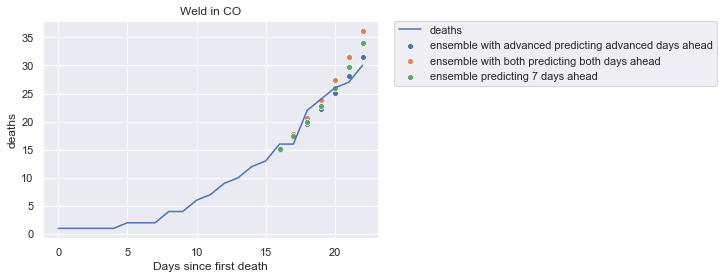

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 63.4
Respiratory Mortality: 57.93
PopulationEstimate2018: 314305.0
#ICU_beds: 26
MedianAge2010: 33.1
Smokers_Percentage: 13.748363782
DiabetesPercentage: 6.9
HeartDiseaseMortality: 132.8
#Hospitals: 1


Worcester in MA


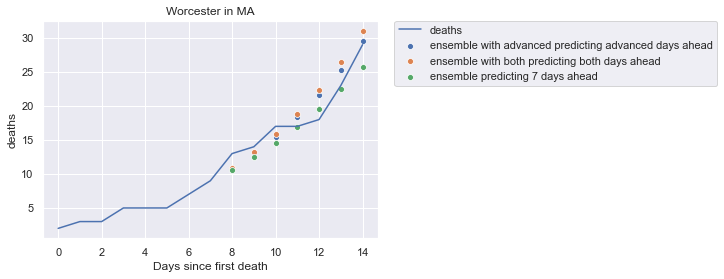

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 528.6
Respiratory Mortality: 51.87
PopulationEstimate2018: 830839.0
#ICU_beds: 169
MedianAge2010: 39.2
Smokers_Percentage: 13.804747585
DiabetesPercentage: 7.9
HeartDiseaseMortality: 146.6
#Hospitals: 8


Cobb in GA


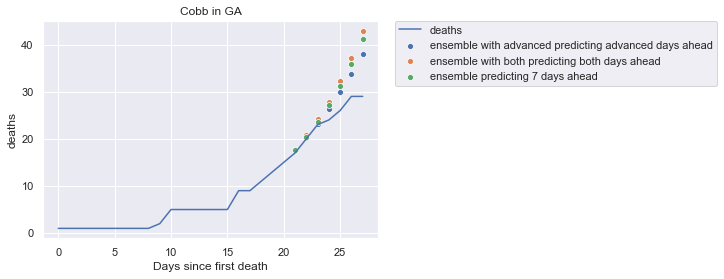

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2026.5
Respiratory Mortality: 46.80
PopulationEstimate2018: 756865.0
#ICU_beds: 119
MedianAge2010: 35.4
Smokers_Percentage: 12.634027364
DiabetesPercentage: 8.4
HeartDiseaseMortality: 139.7
#Hospitals: 2


Mahoning in OH


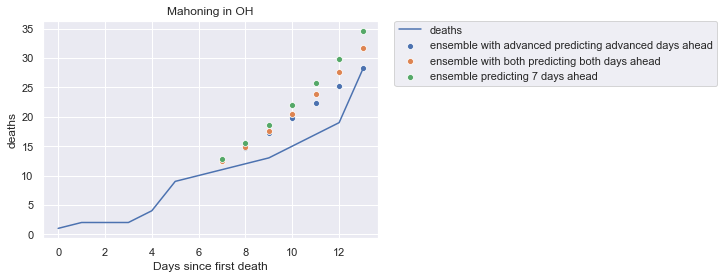

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 580.2
Respiratory Mortality: 58.95
PopulationEstimate2018: 229642.0
#ICU_beds: 67
MedianAge2010: 42.9
Smokers_Percentage: 19.889566928
DiabetesPercentage: 10.3
HeartDiseaseMortality: 218.4
#Hospitals: 3


Mercer in NJ


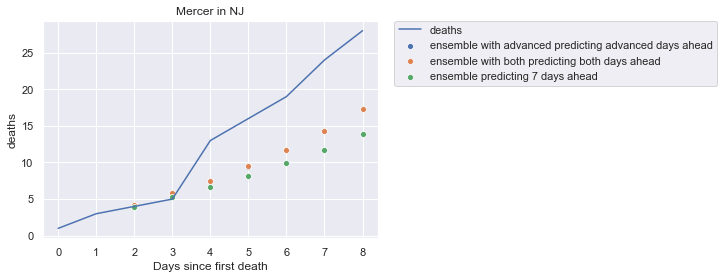

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1632.2
Respiratory Mortality: 39.97
PopulationEstimate2018: 369811.0
#ICU_beds: 92
MedianAge2010: 37.8
Smokers_Percentage: 13.55615998
DiabetesPercentage: 8.1
HeartDiseaseMortality: 158.5
#Hospitals: 4


The District in DC


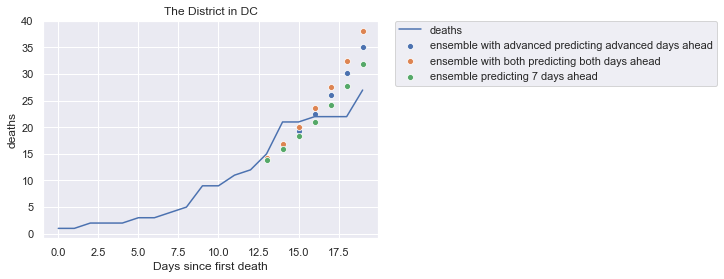

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 9856.5
Respiratory Mortality: 30.21
PopulationEstimate2018: 702455.0
#ICU_beds: 314
MedianAge2010: 33.8
Smokers_Percentage: 15.965592149
DiabetesPercentage: 8.8
HeartDiseaseMortality: 202.1
#Hospitals: 6


Montgomery in MD


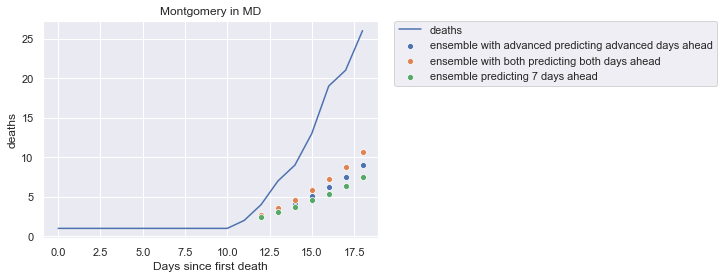

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1978.2
Respiratory Mortality: 26.31
PopulationEstimate2018: 1052567.0
#ICU_beds: 150
MedianAge2010: 38.5
Smokers_Percentage: 8.1757134357
DiabetesPercentage: 7
HeartDiseaseMortality: 104.5
#Hospitals: 6


Caddo in LA


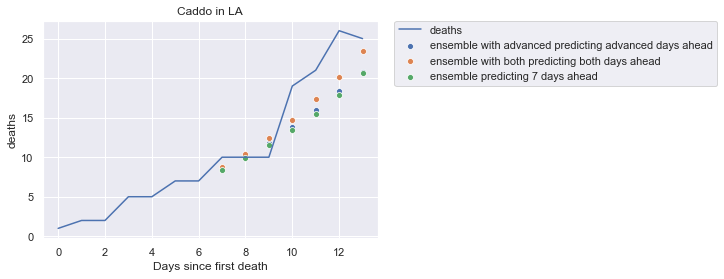

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 290.2
Respiratory Mortality: 69.70
PopulationEstimate2018: 242922.0
#ICU_beds: 107
MedianAge2010: 36.4
Smokers_Percentage: 21.923980452
DiabetesPercentage: 11.5
HeartDiseaseMortality: 163.7
#Hospitals: 5


Monroe in NY


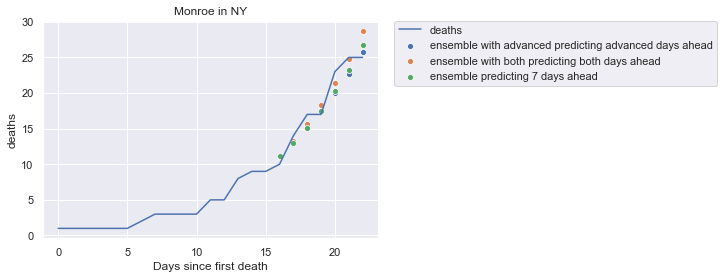

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1132.6
Respiratory Mortality: 37.67
PopulationEstimate2018: 742474.0
#ICU_beds: 191
MedianAge2010: 38.5
Smokers_Percentage: 15.151442269
DiabetesPercentage: 8.4
HeartDiseaseMortality: 149.3
#Hospitals: 5


Bristol in MA


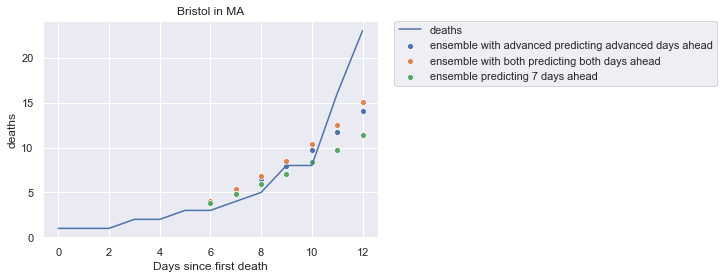

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 991.3
Respiratory Mortality: 48.88
PopulationEstimate2018: 564022.0
#ICU_beds: 96
MedianAge2010: 39.8
Smokers_Percentage: 15.01321279
DiabetesPercentage: 9.2
HeartDiseaseMortality: 154.3
#Hospitals: 4


Delaware in PA


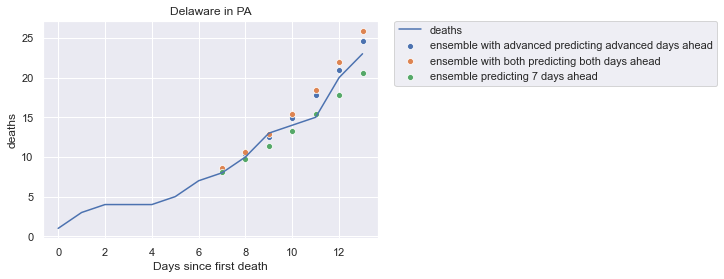

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3040.5
Respiratory Mortality: 53.66
PopulationEstimate2018: 564751.0
#ICU_beds: 100
MedianAge2010: 38.7
Smokers_Percentage: 14.917709668
DiabetesPercentage: 8.9
HeartDiseaseMortality: 173.2
#Hospitals: 4


Lake in IL


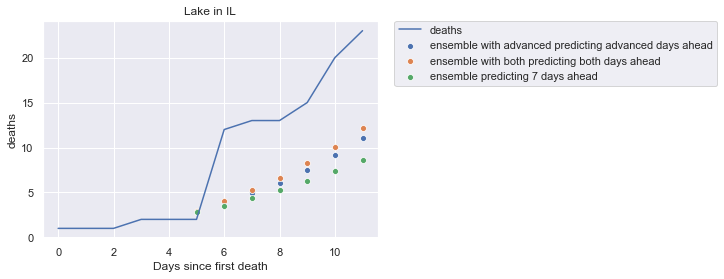

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1585.6
Respiratory Mortality: 43.74
PopulationEstimate2018: 700832.0
#ICU_beds: 108
MedianAge2010: 36.7
Smokers_Percentage: 13.759033259
DiabetesPercentage: 7.8
HeartDiseaseMortality: 133.1
#Hospitals: 6


Harris in TX


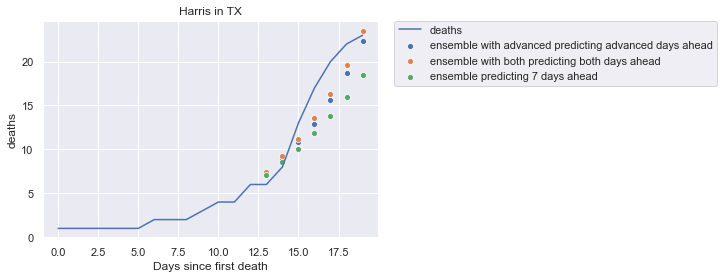

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2402.4
Respiratory Mortality: 39.89
PopulationEstimate2018: 4698619.0
#ICU_beds: 918
MedianAge2010: 32.2
Smokers_Percentage: 13.852121658
DiabetesPercentage: 10.3
HeartDiseaseMortality: 163.0
#Hospitals: 34


Cuyahoga in OH


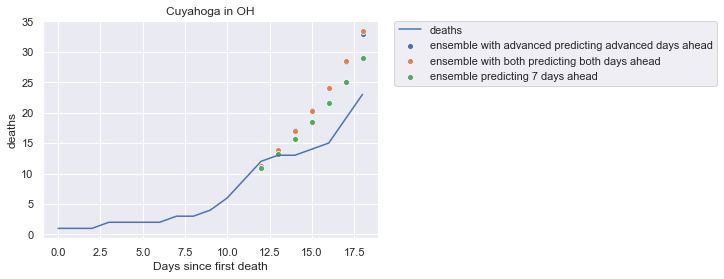

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2800.0
Respiratory Mortality: 48.47
PopulationEstimate2018: 1243857.0
#ICU_beds: 680
MedianAge2010: 40.2
Smokers_Percentage: 20.03452224
DiabetesPercentage: 9.3
HeartDiseaseMortality: 198.9
#Hospitals: 15


Jefferson in CO


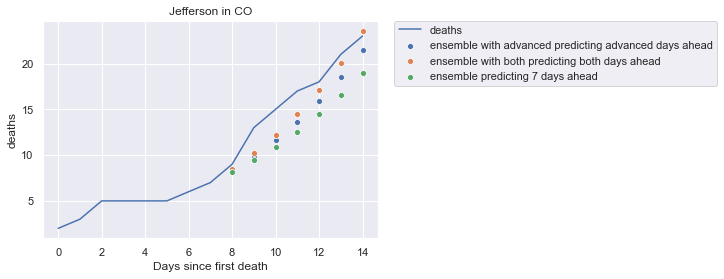

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 699.5
Respiratory Mortality: 57.93
PopulationEstimate2018: 580233.0
#ICU_beds: 94
MedianAge2010: 40.4
Smokers_Percentage: 12.320125467
DiabetesPercentage: 5.1
HeartDiseaseMortality: 135.9
#Hospitals: 4


Bucks in PA


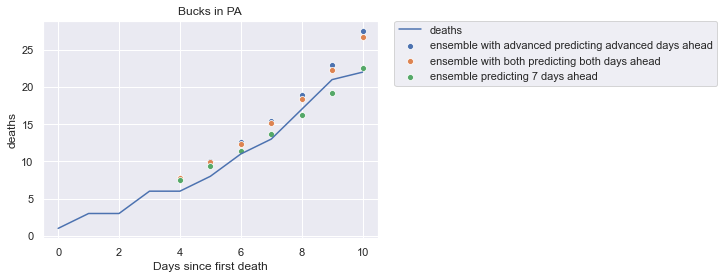

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1034.7
Respiratory Mortality: 48.71
PopulationEstimate2018: 628195.0
#ICU_beds: 90
MedianAge2010: 42.0
Smokers_Percentage: 14.369768279
DiabetesPercentage: 6.4
HeartDiseaseMortality: 139.8
#Hospitals: 7


Sacramento in CA


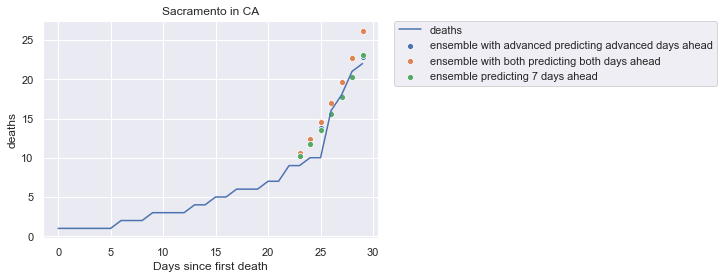

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1470.8
Respiratory Mortality: 49.15
PopulationEstimate2018: 1540975.0
#ICU_beds: 396
MedianAge2010: 34.8
Smokers_Percentage: 11.550028552
DiabetesPercentage: 8.9
HeartDiseaseMortality: 160.0
#Hospitals: 8


Camden in NJ


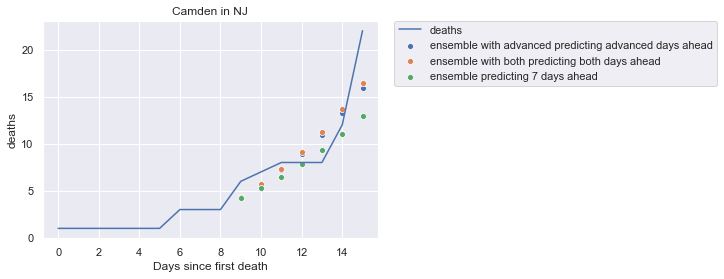

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2321.5
Respiratory Mortality: 48.33
PopulationEstimate2018: 507078.0
#ICU_beds: 199
MedianAge2010: 37.9
Smokers_Percentage: 16.134609166
DiabetesPercentage: 10.7
HeartDiseaseMortality: 180.8
#Hospitals: 4


Sussex in NJ


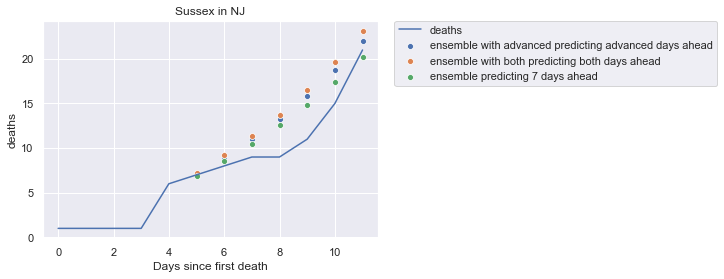

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 287.6
Respiratory Mortality: 50.67
PopulationEstimate2018: 140799.0
#ICU_beds: 10
MedianAge2010: 41.8
Smokers_Percentage: 13.757305722
DiabetesPercentage: 6.9
HeartDiseaseMortality: 169.4
#Hospitals: 1


Franklin in MA


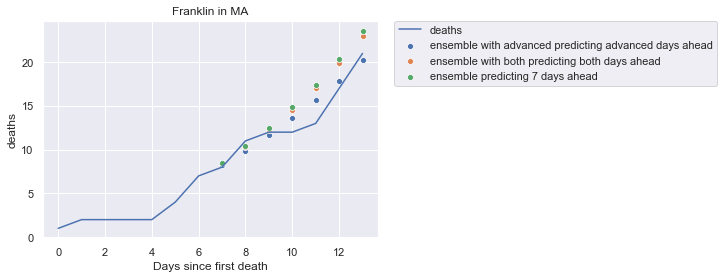

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 102.1
Respiratory Mortality: 54.97
PopulationEstimate2018: 70963.0
#ICU_beds: 6
MedianAge2010: 44.2
Smokers_Percentage: 13.611180122
DiabetesPercentage: 9.5
HeartDiseaseMortality: 147.2
#Hospitals: 1


San Mateo in CA


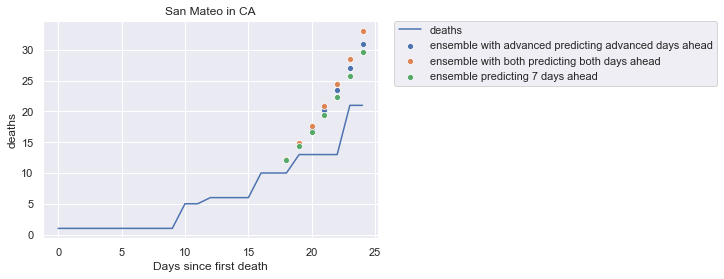

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1602.2
Respiratory Mortality: 30.47
PopulationEstimate2018: 769545.0
#ICU_beds: 131
MedianAge2010: 39.3
Smokers_Percentage: 8.6133573373
DiabetesPercentage: 6.8
HeartDiseaseMortality: 110.1
#Hospitals: 7


Whatcom in WA


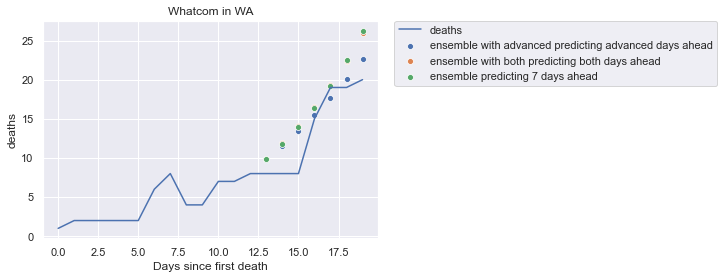

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 95.5
Respiratory Mortality: 46.11
PopulationEstimate2018: 225685.0
#ICU_beds: 24
MedianAge2010: 36.6
Smokers_Percentage: 13.724807685
DiabetesPercentage: 7.5
HeartDiseaseMortality: 134.3
#Hospitals: 1


Berkshire in MA


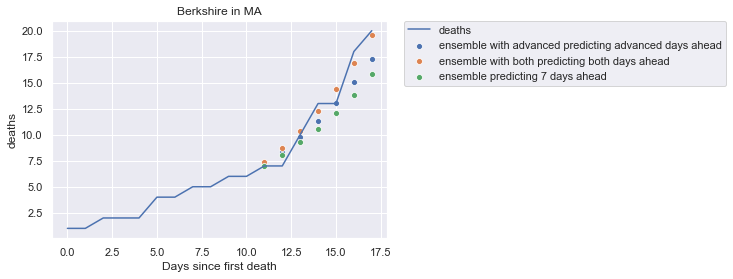

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 141.6
Respiratory Mortality: 52.94
PopulationEstimate2018: 126348.0
#ICU_beds: 24
MedianAge2010: 44.7
Smokers_Percentage: 13.782954088
DiabetesPercentage: 7.8
HeartDiseaseMortality: 147.5
#Hospitals: 2


San Bernardino in CA


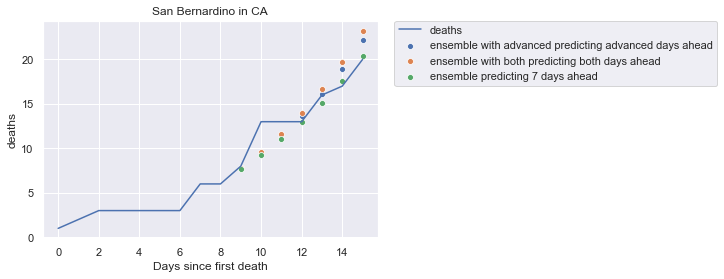

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 101.5
Respiratory Mortality: 63.24
PopulationEstimate2018: 2171603.0
#ICU_beds: 410
MedianAge2010: 31.7
Smokers_Percentage: 12.628276552
DiabetesPercentage: 9.4
HeartDiseaseMortality: 181.4
#Hospitals: 18


Dallas in TX


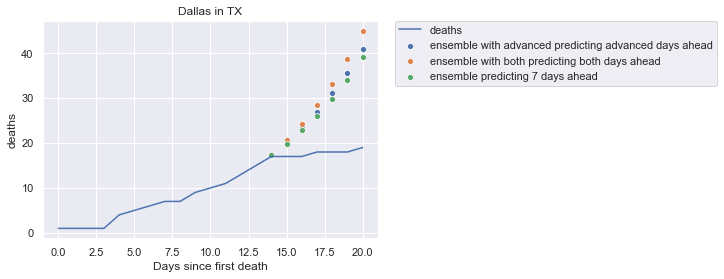

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2718.0
Respiratory Mortality: 47.90
PopulationEstimate2018: 2637772.0
#ICU_beds: 614
MedianAge2010: 32.5
Smokers_Percentage: 14.893746644
DiabetesPercentage: 8.4
HeartDiseaseMortality: 171.3
#Hospitals: 24


Arapahoe in CO


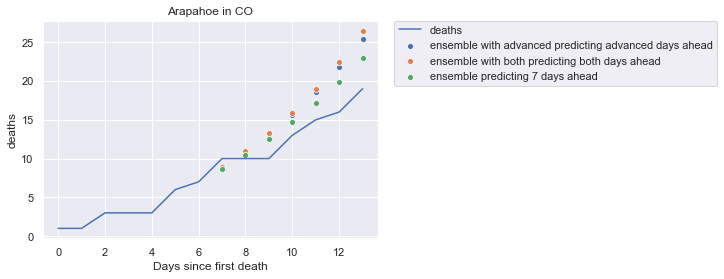

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 716.7
Respiratory Mortality: 57.93
PopulationEstimate2018: 651215.0
#ICU_beds: 127
MedianAge2010: 35.7
Smokers_Percentage: 13.263552471
DiabetesPercentage: 6.8
HeartDiseaseMortality: 112.3
#Hospitals: 3


Kane in IL


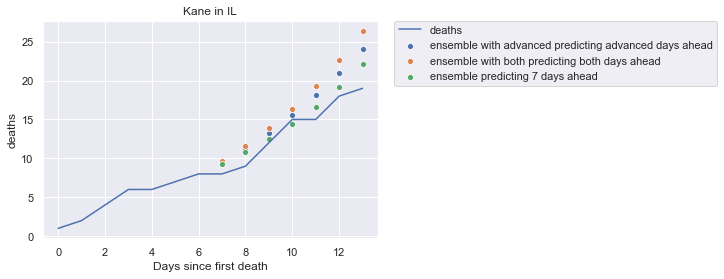

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 990.8
Respiratory Mortality: 43.66
PopulationEstimate2018: 534216.0
#ICU_beds: 103
MedianAge2010: 34.5
Smokers_Percentage: 13.14262051
DiabetesPercentage: 8.8
HeartDiseaseMortality: 132.0
#Hospitals: 5


St. Charles in LA


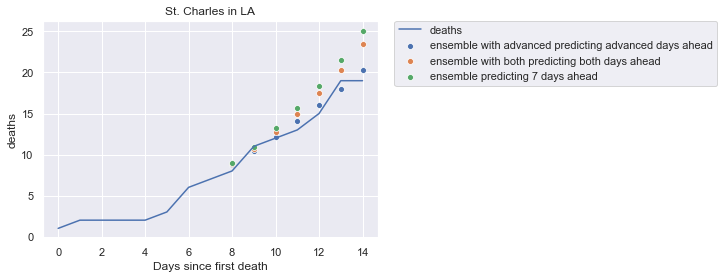

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 189.1
Respiratory Mortality: 49.11
PopulationEstimate2018: 52879.0
#ICU_beds: 8
MedianAge2010: 36.5
Smokers_Percentage: 18.724473708
DiabetesPercentage: 10.1
HeartDiseaseMortality: 186.3
#Hospitals: 1


Bexar in TX


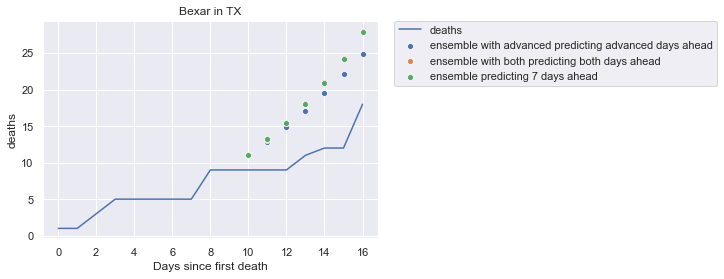

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1383.1
Respiratory Mortality: 44.73
PopulationEstimate2018: 1986049.0
#ICU_beds: 648
MedianAge2010: 32.8
Smokers_Percentage: 14.899297572
DiabetesPercentage: 8.5
HeartDiseaseMortality: 172.9
#Hospitals: 13


Carroll in MD


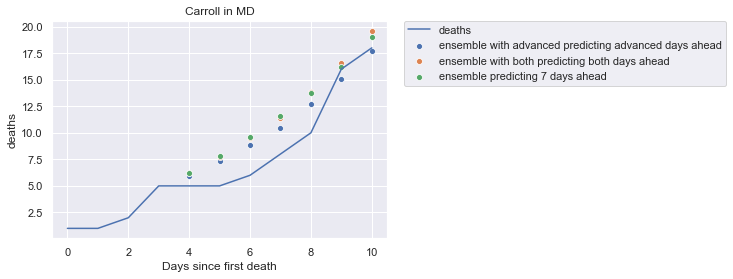

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 373.4
Respiratory Mortality: 58.31
PopulationEstimate2018: 168429.0
#ICU_beds: 10
MedianAge2010: 41.1
Smokers_Percentage: 12.630102677
DiabetesPercentage: 8.3
HeartDiseaseMortality: 175.2
#Hospitals: 1


Benton in WA


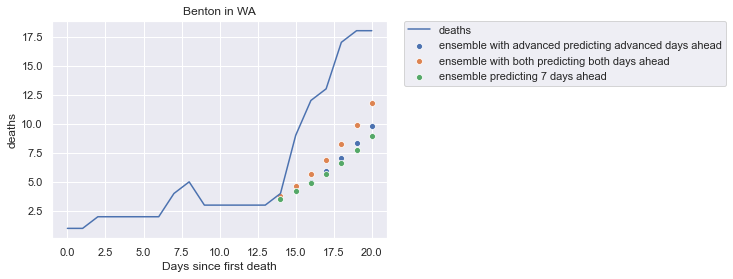

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 103.0
Respiratory Mortality: 56.48
PopulationEstimate2018: 201877.0
#ICU_beds: 44
MedianAge2010: 35.6
Smokers_Percentage: 13.078767464
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.1
#Hospitals: 3


Sumner in TN


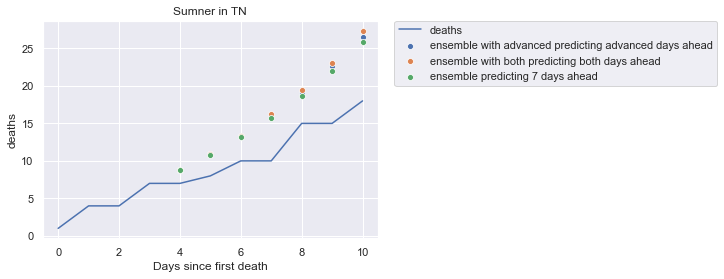

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 303.4
Respiratory Mortality: 60.43
PopulationEstimate2018: 187149.0
#ICU_beds: 38
MedianAge2010: 38.6
Smokers_Percentage: 18.136700439
DiabetesPercentage: 7.1
HeartDiseaseMortality: 172.2
#Hospitals: 2


St. Tammany in LA


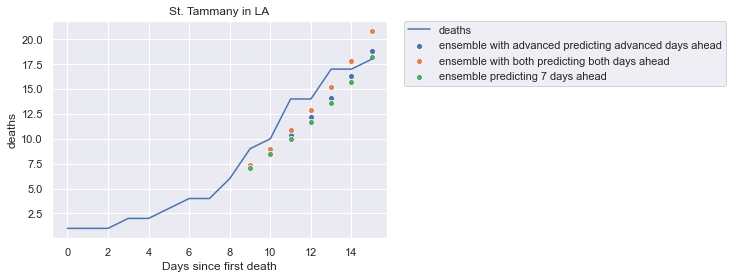

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 276.4
Respiratory Mortality: 59.64
PopulationEstimate2018: 258111.0
#ICU_beds: 149
MedianAge2010: 39.3
Smokers_Percentage: 17.709280575
DiabetesPercentage: 9.6
HeartDiseaseMortality: 165.8
#Hospitals: 6


Yakima in WA


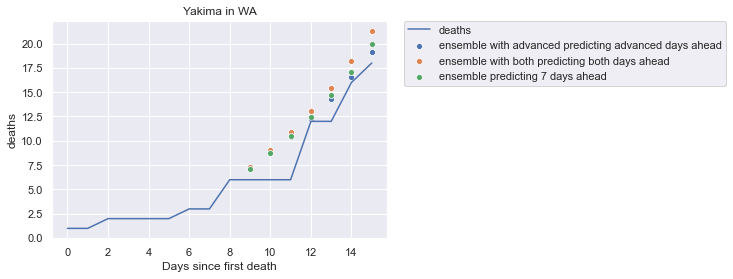

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 56.6
Respiratory Mortality: 51.81
PopulationEstimate2018: 251446.0
#ICU_beds: 52
MedianAge2010: 32.2
Smokers_Percentage: 14.442937059
DiabetesPercentage: 10.7
HeartDiseaseMortality: 171.6
#Hospitals: 4


Tarrant in TX


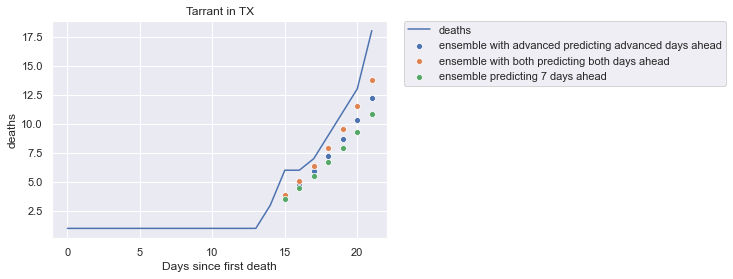

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2094.7
Respiratory Mortality: 57.12
PopulationEstimate2018: 2084931.0
#ICU_beds: 409
MedianAge2010: 33.4
Smokers_Percentage: 14.048999673
DiabetesPercentage: 10.3
HeartDiseaseMortality: 158.3
#Hospitals: 22


Hennepin in MN


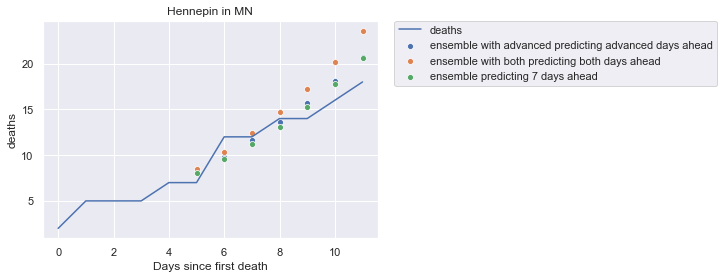

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2081.7
Respiratory Mortality: 45.99
PopulationEstimate2018: 1259428.0
#ICU_beds: 311
MedianAge2010: 35.9
Smokers_Percentage: 11.889587779
DiabetesPercentage: 6.4
HeartDiseaseMortality: 98.1
#Hospitals: 8


Shelby in TN


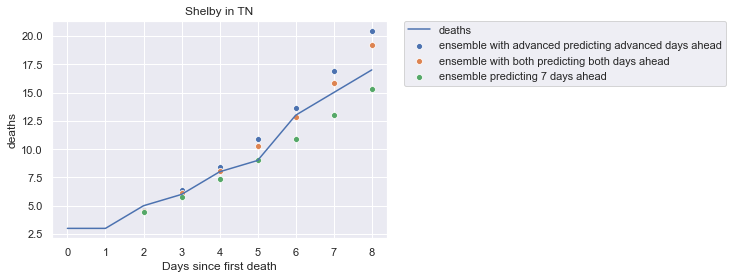

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1215.5
Respiratory Mortality: 50.15
PopulationEstimate2018: 935764.0
#ICU_beds: 277
MedianAge2010: 34.6
Smokers_Percentage: 20.096967848
DiabetesPercentage: 11.4
HeartDiseaseMortality: 202.4
#Hospitals: 6


Orange in CA


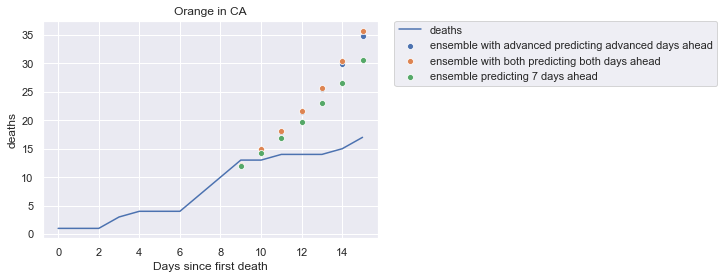

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3807.7
Respiratory Mortality: 35.15
PopulationEstimate2018: 3185968.0
#ICU_beds: 651
MedianAge2010: 36.2
Smokers_Percentage: 9.311197445
DiabetesPercentage: 7.8
HeartDiseaseMortality: 133.0
#Hospitals: 24


Gwinnett in GA


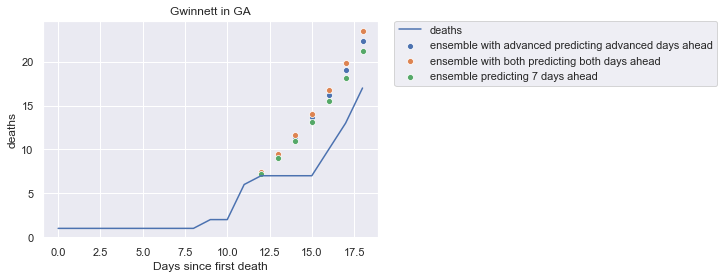

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1871.2
Respiratory Mortality: 49.15
PopulationEstimate2018: 927781.0
#ICU_beds: 82
MedianAge2010: 33.7
Smokers_Percentage: 14.495134254
DiabetesPercentage: 10.9
HeartDiseaseMortality: 136.0
#Hospitals: 3


Northampton in PA


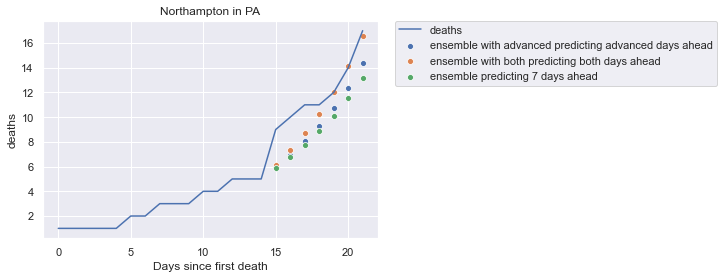

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 805.4
Respiratory Mortality: 40.00
PopulationEstimate2018: 304807.0
#ICU_beds: 64
MedianAge2010: 40.9
Smokers_Percentage: 16.080490415
DiabetesPercentage: 9.2
HeartDiseaseMortality: 150.7
#Hospitals: 4


Monroe in PA


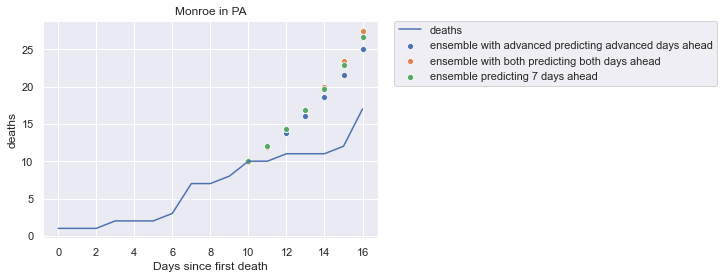

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 279.2
Respiratory Mortality: 52.05
PopulationEstimate2018: 169507.0
#ICU_beds: 44
MedianAge2010: 40.3
Smokers_Percentage: 17.37500376
DiabetesPercentage: 7.1
HeartDiseaseMortality: 168.4
#Hospitals: 2


Burlington in NJ


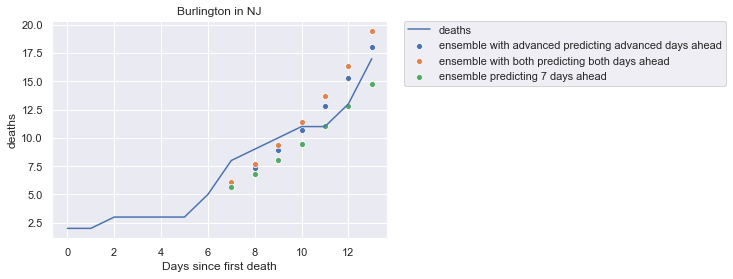

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 561.9
Respiratory Mortality: 45.47
PopulationEstimate2018: 445384.0
#ICU_beds: 82
MedianAge2010: 40.4
Smokers_Percentage: 12.445638161
DiabetesPercentage: 9.9
HeartDiseaseMortality: 167.6
#Hospitals: 3


Pima in AZ


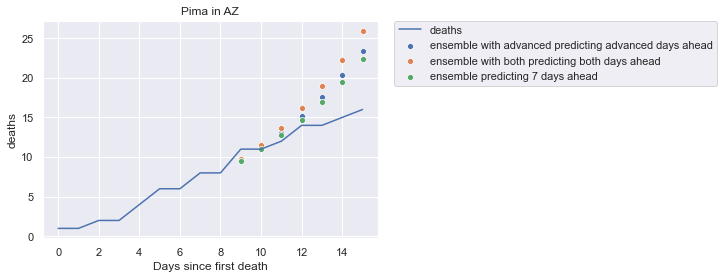

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 106.7
Respiratory Mortality: 49.95
PopulationEstimate2018: 1039073.0
#ICU_beds: 296
MedianAge2010: 37.7
Smokers_Percentage: 14.916461188
DiabetesPercentage: 7.2
HeartDiseaseMortality: 140.0
#Hospitals: 9


Lancaster in PA


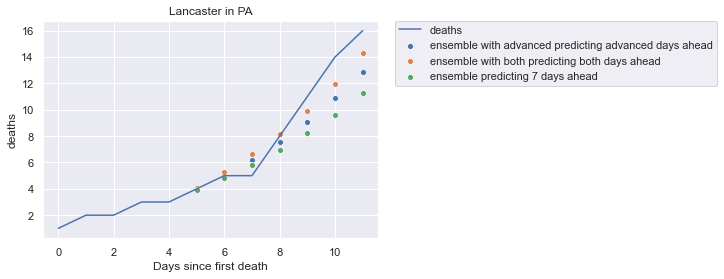

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 550.4
Respiratory Mortality: 43.34
PopulationEstimate2018: 543557.0
#ICU_beds: 64
MedianAge2010: 38.2
Smokers_Percentage: 14.89888061
DiabetesPercentage: 8.2
HeartDiseaseMortality: 154.3
#Hospitals: 3


Lucas in OH


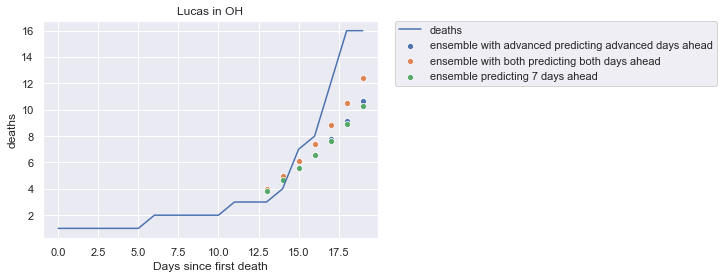

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1296.2
Respiratory Mortality: 70.47
PopulationEstimate2018: 429899.0
#ICU_beds: 251
MedianAge2010: 37.0
Smokers_Percentage: 21.087334662
DiabetesPercentage: 11.6
HeartDiseaseMortality: 214.4
#Hospitals: 7


Alameda in CA


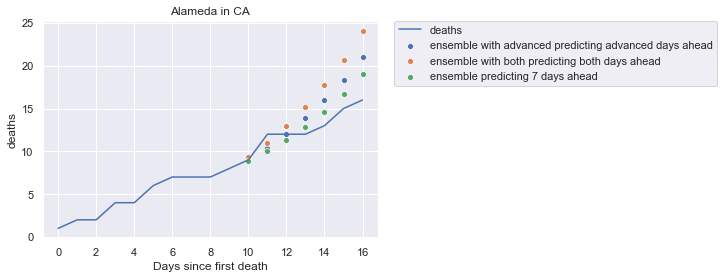

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2043.6
Respiratory Mortality: 36.12
PopulationEstimate2018: 1666753.0
#ICU_beds: 282
MedianAge2010: 36.6
Smokers_Percentage: 9.7327103382
DiabetesPercentage: 6.7
HeartDiseaseMortality: 114.3
#Hospitals: 12


Tulsa in OK


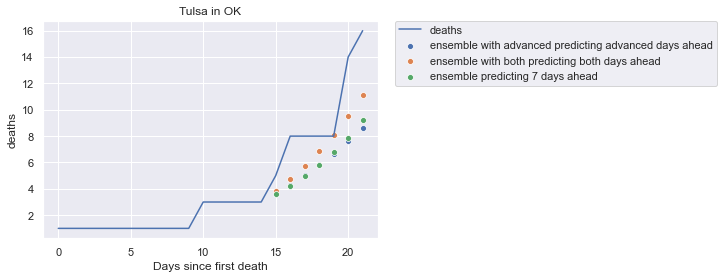

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1058.1
Respiratory Mortality: 68.44
PopulationEstimate2018: 648360.0
#ICU_beds: 379
MedianAge2010: 35.2
Smokers_Percentage: 17.597289961
DiabetesPercentage: 9.4
HeartDiseaseMortality: 226.6
#Hospitals: 12


Coconino in AZ


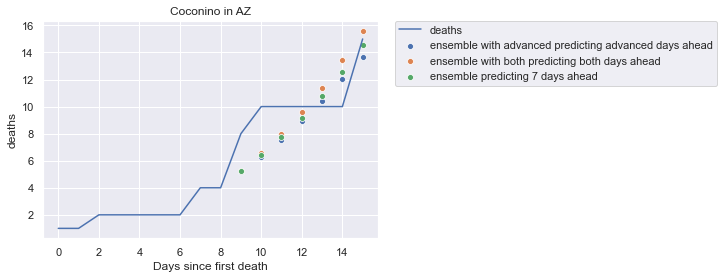

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 7.2
Respiratory Mortality: 46.49
PopulationEstimate2018: 142854.0
#ICU_beds: 41
MedianAge2010: 31.0
Smokers_Percentage: 15.990186028
DiabetesPercentage: 7.7
HeartDiseaseMortality: 124.3
#Hospitals: 3


Pierce in WA


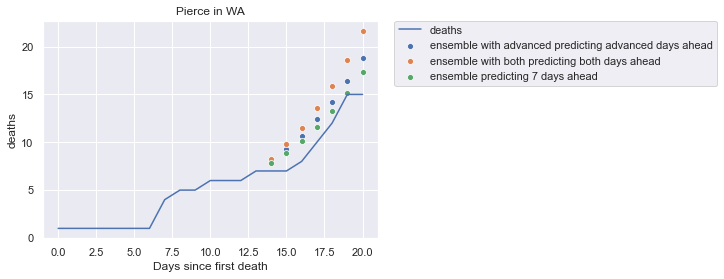

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 476.3
Respiratory Mortality: 58.72
PopulationEstimate2018: 891299.0
#ICU_beds: 189
MedianAge2010: 35.9
Smokers_Percentage: 15.114787239
DiabetesPercentage: 9
HeartDiseaseMortality: 157.2
#Hospitals: 5


Lee in GA


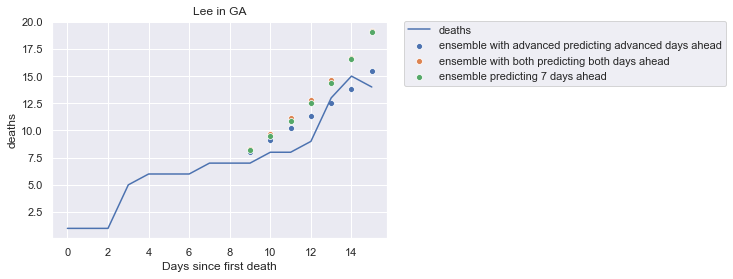

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 79.5
Respiratory Mortality: 71.72
PopulationEstimate2018: 29764.0
#ICU_beds: 0
MedianAge2010: 36.0
Smokers_Percentage: 15.883967596
DiabetesPercentage: 24.6
HeartDiseaseMortality: 185.8
#Hospitals: 0


Dutchess in NY


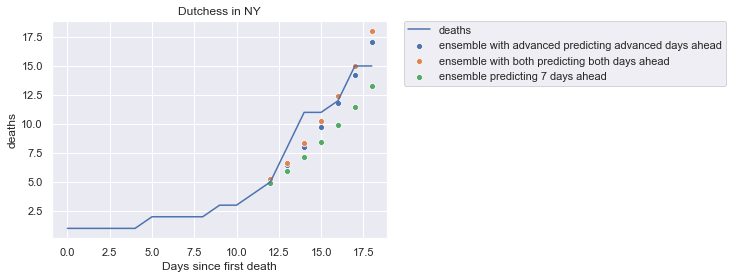

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 373.9
Respiratory Mortality: 46.90
PopulationEstimate2018: 293718.0
#ICU_beds: 51
MedianAge2010: 40.2
Smokers_Percentage: 15.040865509
DiabetesPercentage: 7.7
HeartDiseaseMortality: 178.6
#Hospitals: 2


Oklahoma in OK


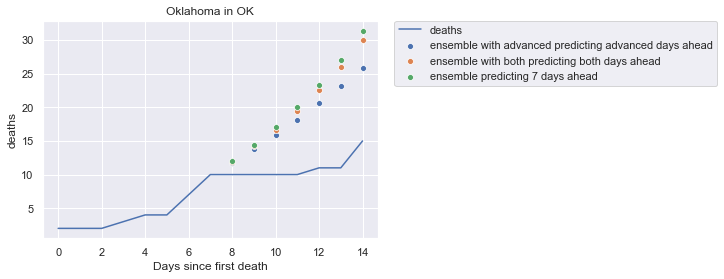

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1013.9
Respiratory Mortality: 77.84
PopulationEstimate2018: 792582.0
#ICU_beds: 300
MedianAge2010: 34.3
Smokers_Percentage: 17.411912594
DiabetesPercentage: 10.7
HeartDiseaseMortality: 211.7
#Hospitals: 19


St. Louis in MO


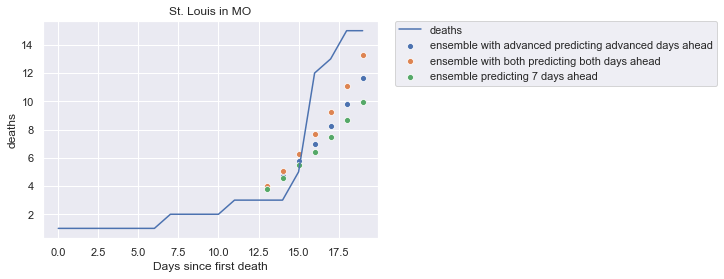

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1967.2
Respiratory Mortality: 43.64
PopulationEstimate2018: 996945.0
#ICU_beds: 468
MedianAge2010: 39.9
Smokers_Percentage: 15.713734105
DiabetesPercentage: 9.7
HeartDiseaseMortality: 173.7
#Hospitals: 9


Ascension in LA


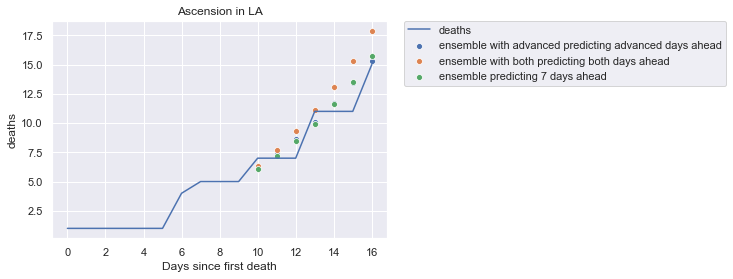

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 369.7
Respiratory Mortality: 60.47
PopulationEstimate2018: 124672.0
#ICU_beds: 0
MedianAge2010: 34.3
Smokers_Percentage: 18.155452803
DiabetesPercentage: 12.9
HeartDiseaseMortality: 206.1
#Hospitals: 1


Hamilton in IN


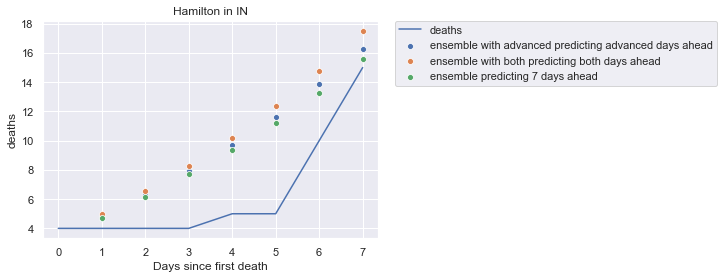

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 696.4
Respiratory Mortality: 48.16
PopulationEstimate2018: 330086.0
#ICU_beds: 10
MedianAge2010: 35.6
Smokers_Percentage: 13.307633994
DiabetesPercentage: 7.6
HeartDiseaseMortality: 129.3
#Hospitals: 5


Chittenden in VT


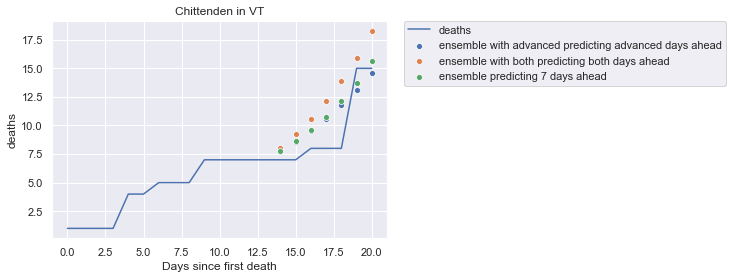

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 291.8
Respiratory Mortality: 45.46
PopulationEstimate2018: 164572.0
#ICU_beds: 46
MedianAge2010: 36.2
Smokers_Percentage: 11.454113693
DiabetesPercentage: 5.6
HeartDiseaseMortality: 129.2
#Hospitals: 1


Putnam in NY


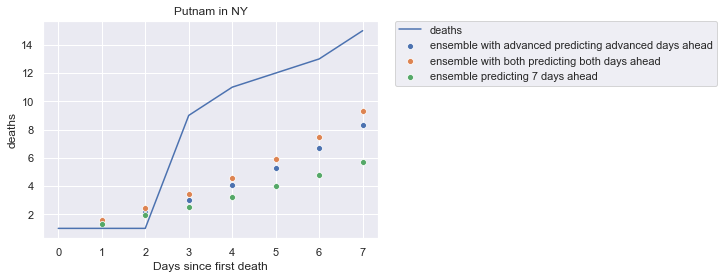

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 432.9
Respiratory Mortality: 35.42
PopulationEstimate2018: 98892.0
#ICU_beds: 10
MedianAge2010: 41.9
Smokers_Percentage: 12.631481982
DiabetesPercentage: 5.1
HeartDiseaseMortality: 165.7
#Hospitals: 1


Lee in FL


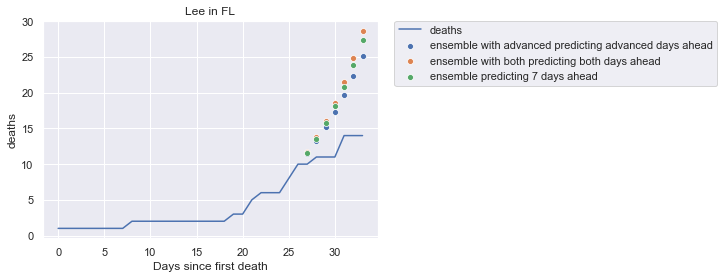

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 788.7
Respiratory Mortality: 40.13
PopulationEstimate2018: 754610.0
#ICU_beds: 141
MedianAge2010: 45.6
Smokers_Percentage: 14.343887724
DiabetesPercentage: 8.1
HeartDiseaseMortality: 131.8
#Hospitals: 4


Cleveland in OK


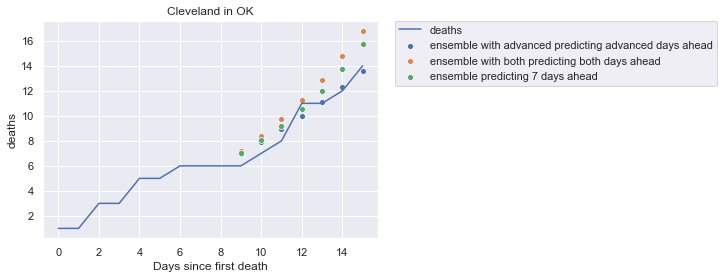

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 474.7
Respiratory Mortality: 68.44
PopulationEstimate2018: 281669.0
#ICU_beds: 77
MedianAge2010: 32.7
Smokers_Percentage: 15.500138403
DiabetesPercentage: 10.5
HeartDiseaseMortality: 169.4
#Hospitals: 1


Terrebonne in LA


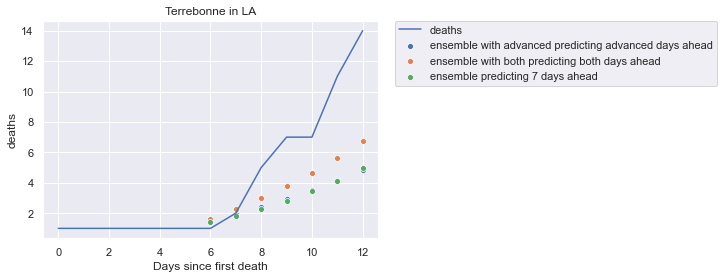

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 90.8
Respiratory Mortality: 64.62
PopulationEstimate2018: 111021.0
#ICU_beds: 26
MedianAge2010: 35.0
Smokers_Percentage: 22.291235625
DiabetesPercentage: 10.5
HeartDiseaseMortality: 202.3
#Hospitals: 3


San Joaquin in CA


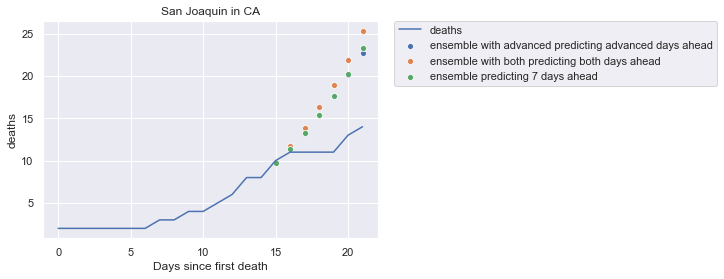

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 492.6
Respiratory Mortality: 57.98
PopulationEstimate2018: 752660.0
#ICU_beds: 121
MedianAge2010: 32.7
Smokers_Percentage: 11.706166224
DiabetesPercentage: 10
HeartDiseaseMortality: 170.8
#Hospitals: 7


Miami in OH


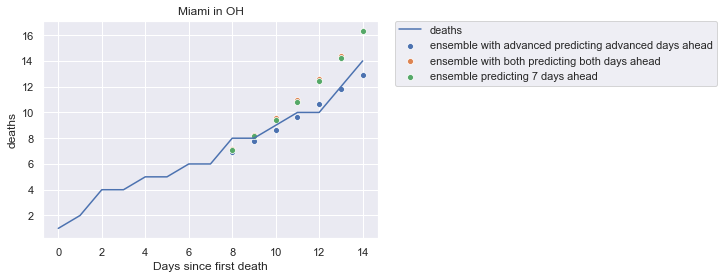

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 252.1
Respiratory Mortality: 63.78
PopulationEstimate2018: 106222.0
#ICU_beds: 10
MedianAge2010: 40.6
Smokers_Percentage: 17.755028181
DiabetesPercentage: 11
HeartDiseaseMortality: 191.0
#Hospitals: 1


Adams in CO


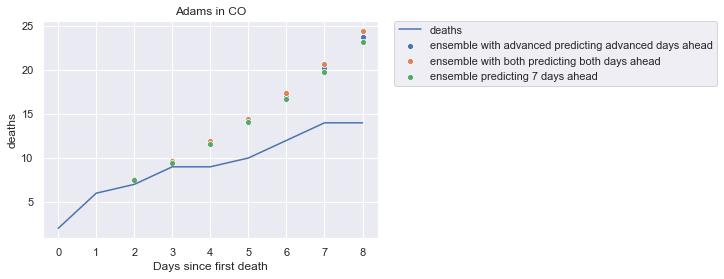

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 378.2
Respiratory Mortality: 57.93
PopulationEstimate2018: 511868.0
#ICU_beds: 168
MedianAge2010: 32.4
Smokers_Percentage: 16.324605425
DiabetesPercentage: 8
HeartDiseaseMortality: 135.7
#Hospitals: 3


Baltimore in MD


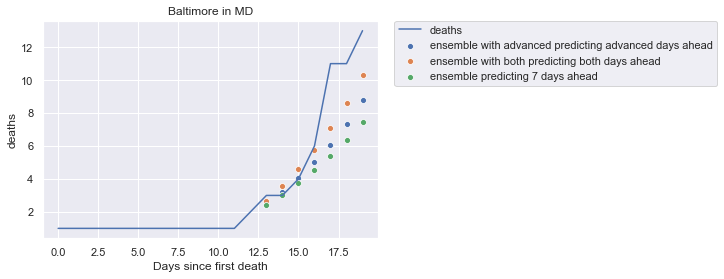

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1345.5
Respiratory Mortality: 40.43
PopulationEstimate2018: 828431.0
#ICU_beds: 123
MedianAge2010: 39.1
Smokers_Percentage: 13.277830309
DiabetesPercentage: 9.4
HeartDiseaseMortality: 172.4
#Hospitals: 5


Hillsborough in NH


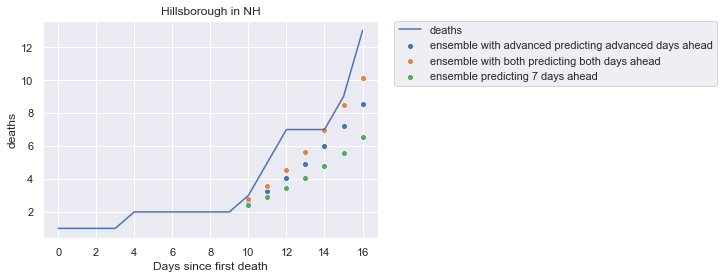

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 457.4
Respiratory Mortality: 57.01
PopulationEstimate2018: 415247.0
#ICU_beds: 62
MedianAge2010: 39.3
Smokers_Percentage: 13.527797003
DiabetesPercentage: 8.4
HeartDiseaseMortality: 146.9
#Hospitals: 5


Davidson in TN


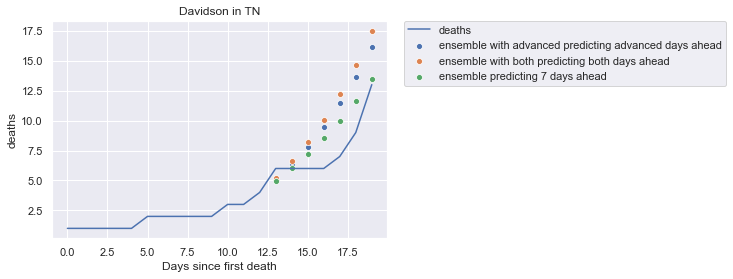

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1243.3
Respiratory Mortality: 57.04
PopulationEstimate2018: 692587.0
#ICU_beds: 614
MedianAge2010: 33.9
Smokers_Percentage: 18.106899483
DiabetesPercentage: 10.1
HeartDiseaseMortality: 189.5
#Hospitals: 9


Tolland in CT


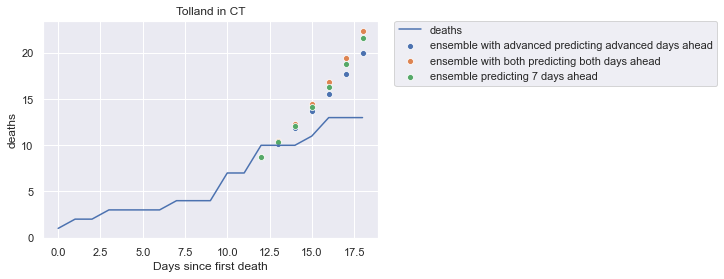

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 372.2
Respiratory Mortality: 45.35
PopulationEstimate2018: 150921.0
#ICU_beds: 16
MedianAge2010: 38.3
Smokers_Percentage: 10.543489991
DiabetesPercentage: 7.3
HeartDiseaseMortality: 146.1
#Hospitals: 2


Hamilton in OH


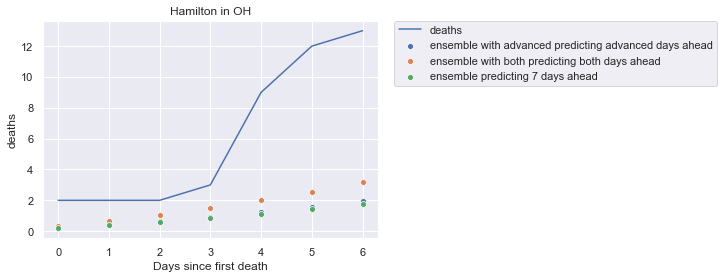

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1976.7
Respiratory Mortality: 58.56
PopulationEstimate2018: 816684.0
#ICU_beds: 297
MedianAge2010: 37.1
Smokers_Percentage: 19.327357226
DiabetesPercentage: 9.9
HeartDiseaseMortality: 173.9
#Hospitals: 8


Wyandotte in KS


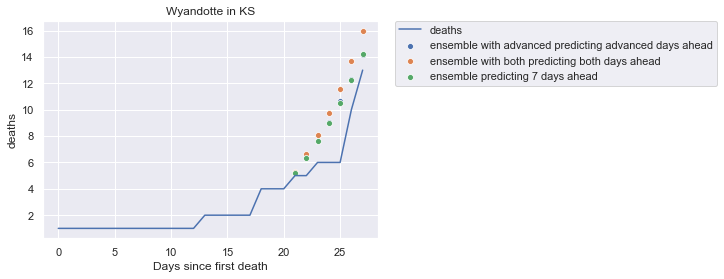

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1039.0
Respiratory Mortality: 68.41
PopulationEstimate2018: 165324.0
#ICU_beds: 145
MedianAge2010: 32.8
Smokers_Percentage: 20.980084625
DiabetesPercentage: 12.4
HeartDiseaseMortality: 167.3
#Hospitals: 2


Beaver in PA


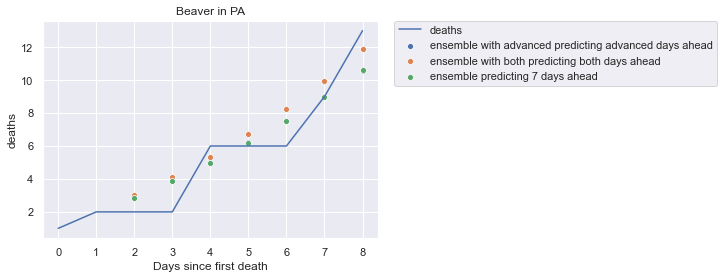

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 392.3
Respiratory Mortality: 53.17
PopulationEstimate2018: 164742.0
#ICU_beds: 20
MedianAge2010: 44.4
Smokers_Percentage: 19.220431873
DiabetesPercentage: 10.6
HeartDiseaseMortality: 188.9
#Hospitals: 1


Washtenaw in MI


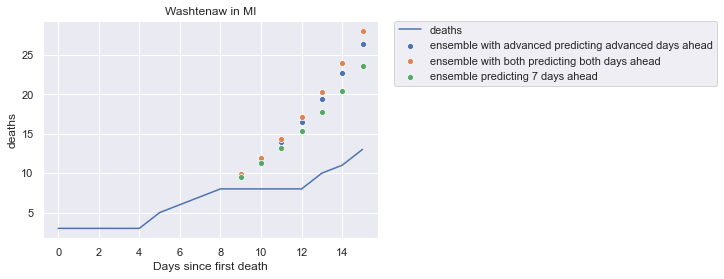

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 488.4
Respiratory Mortality: 41.44
PopulationEstimate2018: 370963.0
#ICU_beds: 92
MedianAge2010: 33.3
Smokers_Percentage: 12.131392772
DiabetesPercentage: 6.8
HeartDiseaseMortality: 149.2
#Hospitals: 4


Lake in IN


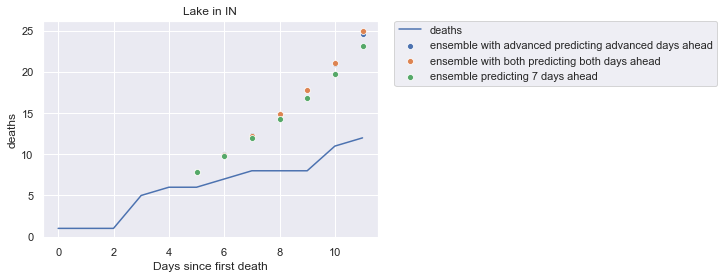

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 994.1
Respiratory Mortality: 59.22
PopulationEstimate2018: 484411.0
#ICU_beds: 188
MedianAge2010: 37.4
Smokers_Percentage: 18.647869199
DiabetesPercentage: 11.5
HeartDiseaseMortality: 184.4
#Hospitals: 9


Litchfield in CT


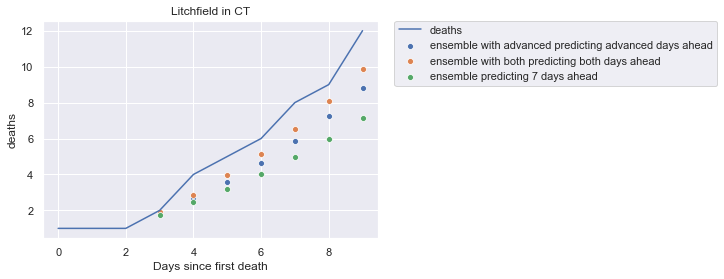

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 206.3
Respiratory Mortality: 50.32
PopulationEstimate2018: 181111.0
#ICU_beds: 21
MedianAge2010: 44.4
Smokers_Percentage: 12.063141174
DiabetesPercentage: 7
HeartDiseaseMortality: 156.1
#Hospitals: 2


Mitchell in GA


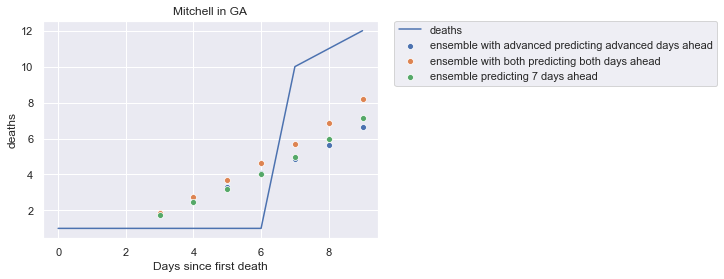

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 45.9
Respiratory Mortality: 58.76
PopulationEstimate2018: 22192.0
#ICU_beds: 0
MedianAge2010: 37.1
Smokers_Percentage: 20.400288606
DiabetesPercentage: 10
HeartDiseaseMortality: 191.5
#Hospitals: 1


Bartow in GA


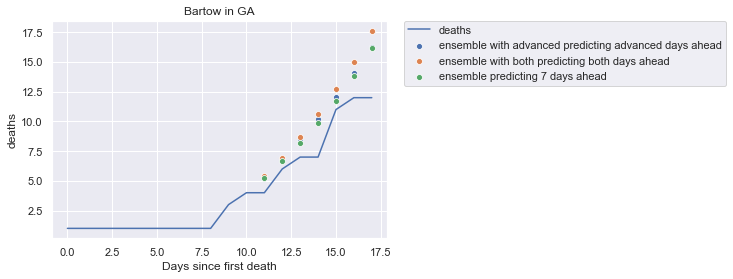

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 218.0
Respiratory Mortality: 80.79
PopulationEstimate2018: 106408.0
#ICU_beds: 21
MedianAge2010: 36.2
Smokers_Percentage: 19.176366416
DiabetesPercentage: 12.7
HeartDiseaseMortality: 196.4
#Hospitals: 1


Franklin in OH


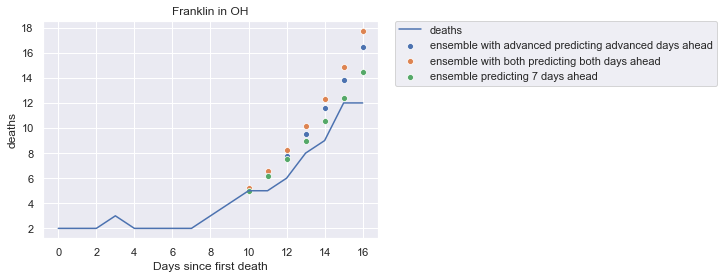

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2186.1
Respiratory Mortality: 65.12
PopulationEstimate2018: 1310300.0
#ICU_beds: 449
MedianAge2010: 33.4
Smokers_Percentage: 19.93468173
DiabetesPercentage: 9.5
HeartDiseaseMortality: 175.9
#Hospitals: 10


DeKalb in GA


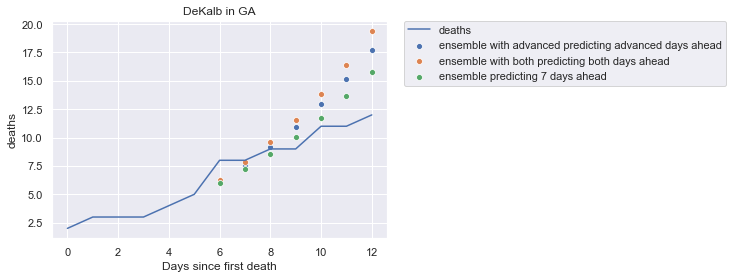

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2585.7
Respiratory Mortality: 37.63
PopulationEstimate2018: 756558.0
#ICU_beds: 168
MedianAge2010: 34.3
Smokers_Percentage: 15.818432089
DiabetesPercentage: 8.5
HeartDiseaseMortality: 132.2
#Hospitals: 3


Spokane in WA


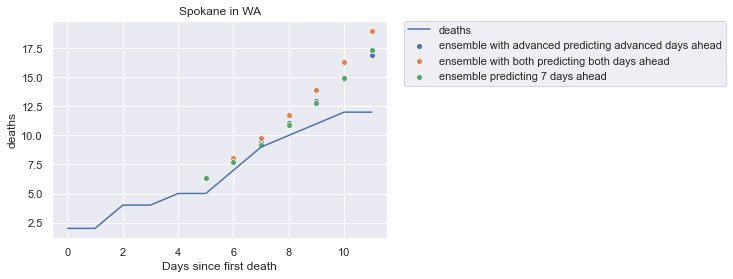

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 267.2
Respiratory Mortality: 63.12
PopulationEstimate2018: 514631.0
#ICU_beds: 113
MedianAge2010: 36.8
Smokers_Percentage: 14.493901558
DiabetesPercentage: 8.5
HeartDiseaseMortality: 137.0
#Hospitals: 4


Summit in OH


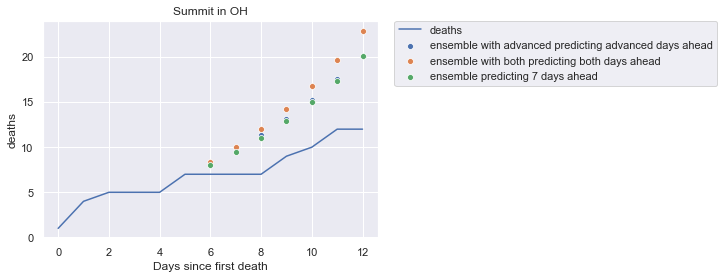

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1312.6
Respiratory Mortality: 65.67
PopulationEstimate2018: 541918.0
#ICU_beds: 170
MedianAge2010: 40.0
Smokers_Percentage: 18.483947403
DiabetesPercentage: 9
HeartDiseaseMortality: 179.7
#Hospitals: 4


Johnson in KS


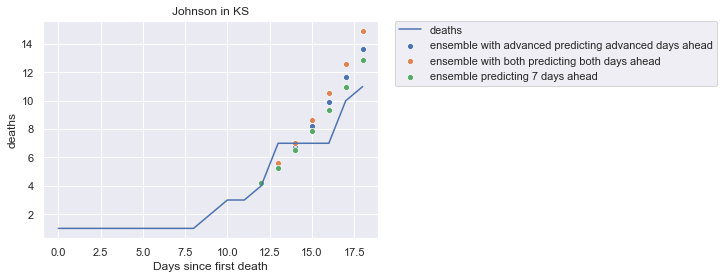

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1149.6
Respiratory Mortality: 41.79
PopulationEstimate2018: 597555.0
#ICU_beds: 110
MedianAge2010: 36.4
Smokers_Percentage: 10.638545632
DiabetesPercentage: 7.1
HeartDiseaseMortality: 112.5
#Hospitals: 9


Barnstable in MA


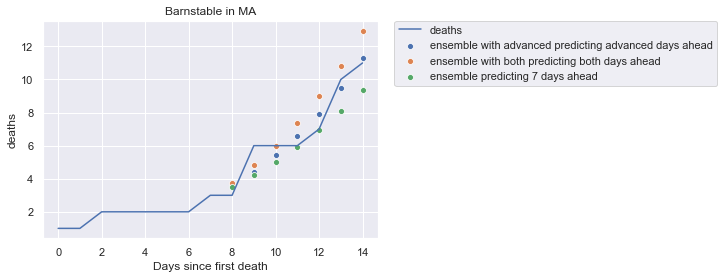

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 548.3
Respiratory Mortality: 42.06
PopulationEstimate2018: 213413.0
#ICU_beds: 34
MedianAge2010: 49.9
Smokers_Percentage: 11.853906316
DiabetesPercentage: 6.1
HeartDiseaseMortality: 143.0
#Hospitals: 2


Madison in IN


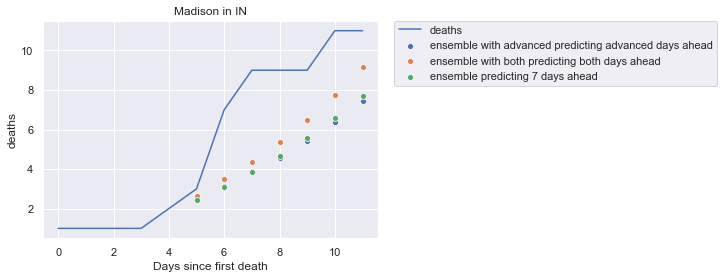

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 291.3
Respiratory Mortality: 74.96
PopulationEstimate2018: 129641.0
#ICU_beds: 21
MedianAge2010: 39.2
Smokers_Percentage: 21.638695544
DiabetesPercentage: 15.6
HeartDiseaseMortality: 182.3
#Hospitals: 3


Luzerne in PA


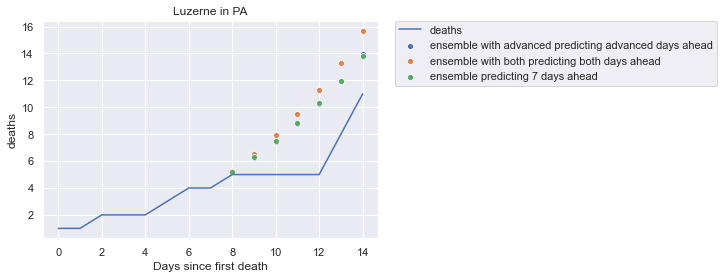

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 360.5
Respiratory Mortality: 50.95
PopulationEstimate2018: 317646.0
#ICU_beds: 71
MedianAge2010: 42.5
Smokers_Percentage: 19.307997325
DiabetesPercentage: 8.8
HeartDiseaseMortality: 197.3
#Hospitals: 3


New Castle in DE


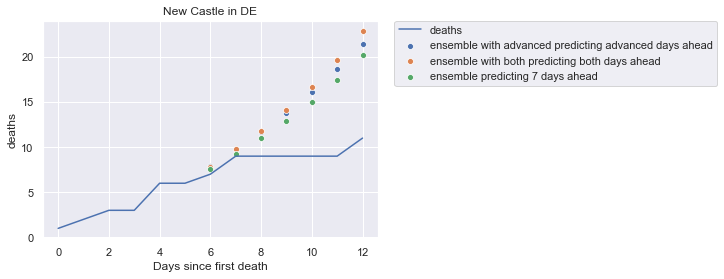

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1263.2
Respiratory Mortality: 49.38
PopulationEstimate2018: 559335.0
#ICU_beds: 119
MedianAge2010: 37.2
Smokers_Percentage: 15.242558128
DiabetesPercentage: 9.4
HeartDiseaseMortality: 153.8
#Hospitals: 2


Dane in WI


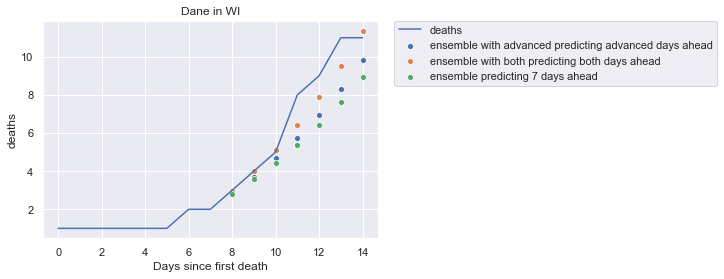

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 407.7
Respiratory Mortality: 42.95
PopulationEstimate2018: 542364.0
#ICU_beds: 39
MedianAge2010: 34.4
Smokers_Percentage: 12.442923628
DiabetesPercentage: 6.1
HeartDiseaseMortality: 124.9
#Hospitals: 4


Bernalillo in NM


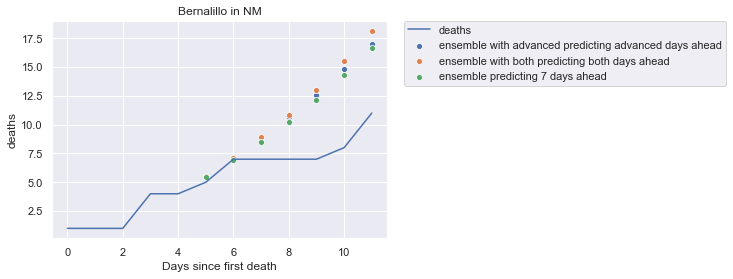

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 570.8
Respiratory Mortality: 53.24
PopulationEstimate2018: 678701.0
#ICU_beds: 138
MedianAge2010: 35.8
Smokers_Percentage: 15.209989631
DiabetesPercentage: 6.4
HeartDiseaseMortality: 139.3
#Hospitals: 5


Lafourche in LA


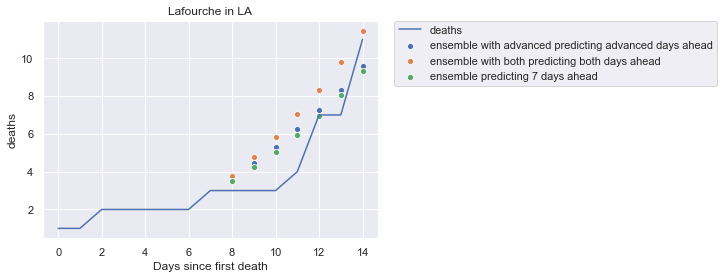

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 90.2
Respiratory Mortality: 47.23
PopulationEstimate2018: 98115.0
#ICU_beds: 21
MedianAge2010: 36.5
Smokers_Percentage: 19.224758245
DiabetesPercentage: 12.3
HeartDiseaseMortality: 177.8
#Hospitals: 3


Orange in FL


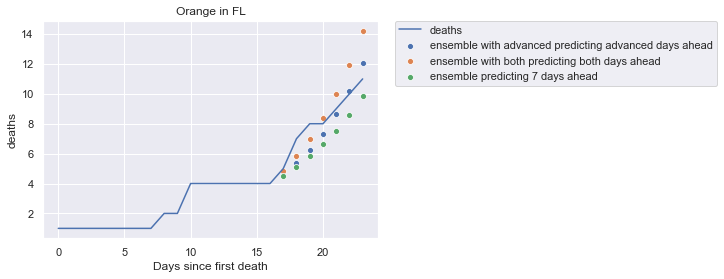

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1268.5
Respiratory Mortality: 45.49
PopulationEstimate2018: 1380645.0
#ICU_beds: 388
MedianAge2010: 33.7
Smokers_Percentage: 15.599881132
DiabetesPercentage: 9.3
HeartDiseaseMortality: 151.0
#Hospitals: 3


Lehigh in PA


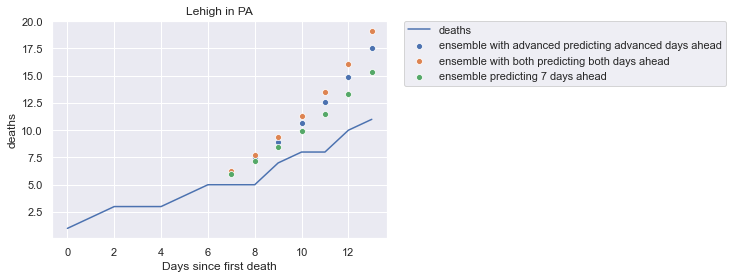

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1012.6
Respiratory Mortality: 42.23
PopulationEstimate2018: 368100.0
#ICU_beds: 143
MedianAge2010: 39.4
Smokers_Percentage: 18.336704588
DiabetesPercentage: 10.4
HeartDiseaseMortality: 151.6
#Hospitals: 3


Anne Arundel in MD


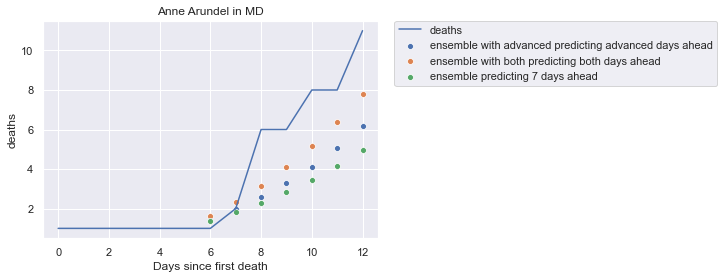

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1295.9
Respiratory Mortality: 47.47
PopulationEstimate2018: 576031.0
#ICU_beds: 53
MedianAge2010: 38.4
Smokers_Percentage: 13.675421228
DiabetesPercentage: 8.8
HeartDiseaseMortality: 161.1
#Hospitals: 2




In [502]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
#         plot_log(row)

        for v in very_important_vars:
            print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')